# Section 1. Data Loading and Initial Inspection

In [66]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Install 'squarify' if not already installed (used for treemap visualisation)
! pip install squarify
import squarify

# For calculating Cramér’s V statistic and performing the Chi-square test
from scipy.stats import chi2_contingency

# For Section 3. Free User Upgrade Analysis – customer segmentation
from sklearn.cluster import KMeans
from matplotlib.ticker import PercentFormatter

# For Section 4. Premium User Churn Analysis – logistic regression modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [67]:
# Load the data source file
df = pd.read_excel("Spotify_data.xlsx", sheet_name="Sheet1")

# Display the raw dataframe
df

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan-Rs 179/month,Podcast,Melody,Night,Sadness or melancholy,leisure time,Playlists,3,Daily,Comedy,Interview,Both,Both,Ok
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan- Rs 119/ month,Podcast,Rap,Afternoon,Social gatherings or parties,Workout session,Playlists,2,Several times a week,Comedy,Interview,Both,NaN,Satisfied
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan-Rs 59/month,Podcast,Pop,Night,Relaxation and stress relief,"Study Hours, While Traveling",Playlists,4,Once a week,Sports,Interview,NaN,Both,Satisfied
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,NaN,Music,Melody,Night,"Relaxation and stress relief, Social gathering...","Office hours, Workout session, leisure time","recommendations, Playlists",4,Never,NaN,NaN,NaN,NaN,Ok
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,NaN,Music,Melody,Night,Relaxation and stress relief,leisure time,"recommendations, Playlists",4,Rarely,Lifestyle and Health,Story telling,Well known individuals,Both,Ok
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,20-35,Female,More than 2 years,"Smartphone, Computer or laptop, Wearable devices",Free (ad-supported),Yes,Student Plan-Rs 59/month,Music,Pop,Morning,"Uplifting and motivational, Sadness or melancholy",While Traveling,recommendations,5,Rarely,Lifestyle and Health,Conversational,Both,Shorter,Ok
516,20-35,Female,More than 2 years,"Smartphone, Computer or laptop",Free (ad-supported),Yes,Student Plan-Rs 59/month,Music,Pop,Night,"Relaxation and stress relief, Uplifting and mo...","While Traveling, Workout session, leisure time",Others,2,Rarely,Comedy,Story telling,Both,Shorter,Ok
517,20-35,Female,More than 2 years,Smartphone,Free (ad-supported),No,Student Plan-Rs 59/month,Music,Pop,Night,Relaxation and stress relief,leisure time,recommendations,3,Never,NaN,Story telling,Both,Shorter,Ok
518,20-35,Female,6 months to 1 year,Smartphone,Premium (paid subscription),Yes,Individual Plan- Rs 119/ month,Music,Melody,Night,"Relaxation and stress relief, Uplifting and mo...","Workout session, leisure time","recommendations, Others",2,Several times a week,Comedy,Conversational,Both,Longer,Satisfied


## 1.1 Basic Structural Checks (Shape, Dtypes, Missing Values, Duplicates)

In [68]:
# Check the basic information and shape of the dataset
print(df.info())
print("\n")
print("The shape of the dataframe:")
print(df.shape)

# Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Age                          520 non-null    object
 1   Gender                       520 non-null    object
 2   spotify_usage_period         520 non-null    object
 3   spotify_listening_device     520 non-null    object
 4   spotify_subscription_plan    520 non-null    object
 5   premium_sub_willingness      520 non-null    object
 6   preffered_premium_plan       312 non-null    object
 7   preferred_listening_content  520 non-null    object
 8   fav_music_genre              520 non-null    object
 9   music_time_slot              520 non-null    object
 10  music_Influencial_mood       520 non-null    object
 11  music_lis_frequency          520 non-null    object
 12  music_expl_method            520 non-null    object
 13  music_recc_rating            520 no

## 1.2 Handling Missing Values and Categorical Variables

There are some missing values in the following columns: `preferred_premium_plan`, `fav_pod_genre`, `preferred_pod_format`, `pod_host_preference`, and `preferred_pod_duration`.

These missing values are likely due to the **optional nature** of those questions — for example:
- Users not interested in Premium may skip questions about Premium plan preference.
- Users who do not listen to podcasts may leave podcast-related questions blank.

Hence, missing categorical responses will be replaced with `"No Response"`.

In [69]:
# Select categorical (object or string) columns
categorical_cols = df.select_dtypes(include='object').columns

print("Categorical columns in the dataset:")
print(list(categorical_cols))

# Replace NaN in categorical columns with "No Response"
df[categorical_cols] = df[categorical_cols].fillna('No Response')

Categorical columns in the dataset:
['Age', 'Gender', 'spotify_usage_period', 'spotify_listening_device', 'spotify_subscription_plan', 'premium_sub_willingness', 'preffered_premium_plan', 'preferred_listening_content', 'fav_music_genre', 'music_time_slot', 'music_Influencial_mood', 'music_lis_frequency', 'music_expl_method', 'pod_lis_frequency', 'fav_pod_genre', 'preffered_pod_format', 'pod_host_preference', 'preffered_pod_duration', 'pod_variety_satisfaction']


## 1.3 Standardising Text Responses

Because the dataset originally used Indian Rupee (INR) pricing labels, the currency of all Premium plans has been standardised to British Pounds (GBP) for consistency.

In [70]:
# Replace old currency labels with GBP equivalents

df['preffered_premium_plan'] = df['preffered_premium_plan'].replace({
    'Family Plan-Rs 179/month': 'Family Plan - GBP 19.99/month',
    'Individual Plan- Rs 119/ month': 'Individual Plan - GBP 11.99/ month',
    'Student Plan-Rs 59/month': 'Student Plan - GBP 5.99/month',
    'Duo plan- Rs 149/month': 'Duo Plan - GBP 16.99/month'
})

## 1.4 Exploring Categorical Variables

After examining the unique values of all categorical variables, I found that several columns — such as `spotify_listening_device`, `music_influential_mood`, `music_list_frequency`, and `music_expl_method` — contain **multiple comma-separated responses** per user (e.g. “Mobile, Laptop, Smart Speaker”).

To accurately capture user preferences, these fields were split by commas, cleaned of whitespace, and expanded into separate entries for frequency counting.

In [71]:
# Loop through each categorical column and print unique values
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df[col].unique())


--- Age ---
['20-35' '12-20' '35-60' '6-12' '60+']

--- Gender ---
['Female' 'Male' 'Others']

--- spotify_usage_period ---
['More than 2 years' '6 months to 1 year' '1 year to 2 years'
 'Less than 6 months']

--- spotify_listening_device ---
['Smart speakers or voice assistants' 'Computer or laptop'
 'Smartphone, Smart speakers or voice assistants' 'Smartphone'
 'Smartphone, Computer or laptop'
 'Smartphone, Computer or laptop, Smart speakers or voice assistants'
 'Smartphone, Wearable devices'
 'Smartphone, Computer or laptop, Wearable devices'
 'Computer or laptop, Wearable devices'
 'Smartphone, Computer or laptop, Smart speakers or voice assistants, Wearable devices'
 'Wearable devices'
 'Smartphone, Smart speakers or voice assistants, Wearable devices'
 'Computer or laptop, Smart speakers or voice assistants'
 'Computer or laptop, Smart speakers or voice assistants, Wearable devices'
 'Smart speakers or voice assistants, Wearable devices']

--- spotify_subscription_plan ---
['Fr

In [72]:
# Split comma-separated values, clean text, and count unique occurrences

# Listening device
device = df['spotify_listening_device'].str.split(',').explode().str.strip()
device = device.to_frame(name="devices")
print("----Listening Devices----")
print(device.value_counts())

# Music-influenced mood
music_mood = df['music_Influencial_mood'].str.split(',').explode().str.strip()
music_mood = music_mood.to_frame(name="mood")
print("\n----Music Influencial Mood----")
print(music_mood.value_counts())

# Music listening frequency
listen_freq = df['music_lis_frequency'].str.split(',').explode().str.strip().str.capitalize()
listen_freq = listen_freq[listen_freq != ""]
listen_freq = listen_freq.to_frame(name="lis_freq")
print("\n----Music Listen Frequency----")
print(listen_freq.value_counts())

# Music exploration method
search_method = df['music_expl_method'].str.split(',').explode().str.strip().str.capitalize()
search_method = search_method.to_frame(name="search")
print("\n----Music  Explorance Mood----")
print(search_method.value_counts())

----Listening Devices----
devices                           
Smartphone                            391
Computer or laptop                    144
Smart speakers or voice assistants     92
Wearable devices                       44
Name: count, dtype: int64

----Music Influencial Mood----
mood                        
Relaxation and stress relief    364
Uplifting and motivational      199
Sadness or melancholy           167
Social gatherings or parties     92
Name: count, dtype: int64

----Music Listen Frequency----
lis_freq         
While traveling      331
Leisure time         263
Workout session      153
Office hours          87
Study hours           85
Before bed             1
Night time             1
Random                 1
Social gatherings      1
When cooking           1
Name: count, dtype: int64

----Music  Explorance Mood----
search         
Playlists          264
Recommendations    259
Others             121
Radio              107
Social media         3
Friends              1
Se

## 1.5 Creating Dummy Variables for Multi-choice Questions
For modelling or statistical analysis, we convert the exploded categorical responses into one-hot encoded dummy variables using `pd.crosstab()`.

In [73]:
# List of columns you want to process
cols_to_process = {
    'spotify_listening_device': 'device',
    'music_Influencial_mood': 'mood',
    'music_lis_frequency': 'lis_freq',
    'music_expl_method': 'search'
}

all_dummies = []

for original_col, new_prefix in cols_to_process.items():
    
    # Step 1 & 2: Split, explode, and clean in one go
    # Create a temporary Series for cleaning
    cleaned_series = (
        df[original_col]
        .str.split(',')
        .explode()
        .str.strip()
        .str.capitalize()
    )
    
    # Step 3: Remove the empty strings
    cleaned_series = cleaned_series[cleaned_series != '']
    
    # Step 4: Create the dummy variables using crosstab
    dummies = pd.crosstab(cleaned_series.index, cleaned_series)
    
    all_dummies.append(dummies)

# Now, combine them all back with your original data
df_stats = pd.concat([df] + all_dummies, axis=1)
df_stats.head()

,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,...,When cooking,While traveling,Workout session,Friends,Others,Playlists,Radio,Recommendations,Search,Social media
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,Free (ad-supported),Yes,Family Plan - GBP 19.99/month,Podcast,Melody,Night,...,0,0,0,0,0,1,0,0,0,0
1,12-20,Male,More than 2 years,Computer or laptop,Free (ad-supported),Yes,Individual Plan - GBP 11.99/ month,Podcast,Rap,Afternoon,...,0,0,1,0,0,1,0,0,0,0
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,Free (ad-supported),Yes,Student Plan - GBP 5.99/month,Podcast,Pop,Night,...,0,1,0,0,0,1,0,0,0,0
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",Free (ad-supported),No,No Response,Music,Melody,Night,...,0,0,1,0,0,1,0,1,0,0
4,20-35,Female,1 year to 2 years,Smartphone,Free (ad-supported),No,No Response,Music,Melody,Night,...,0,0,0,0,0,1,0,1,0,0


# Section 2. Exploratory Data Analysis (EDA)

## 2.1 Overall User Overview

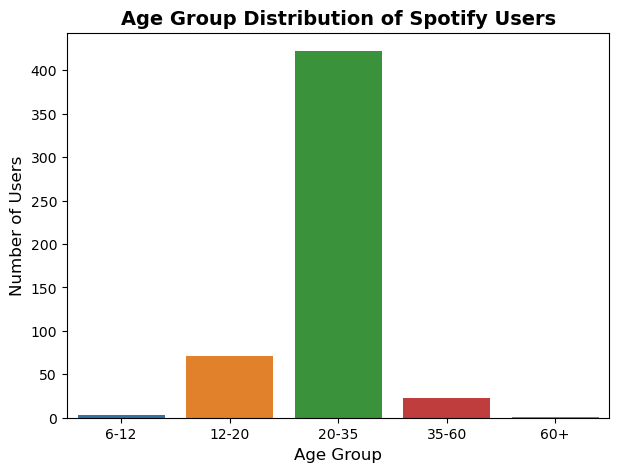

In [74]:
age_order = ['6-12', '12-20', '20-35', '35-60', '60+']
age_count = df['Age'].value_counts().reindex(age_order)

plt.figure(figsize=(7,5))
ax = sns.barplot(x=age_count.index, y=age_count.values)

plt.title('Age Group Distribution of Spotify Users', fontsize=14, fontweight='bold')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

plt.show()

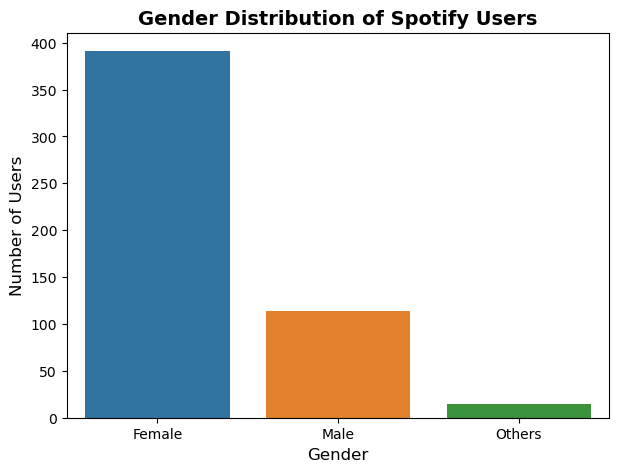

In [75]:
gender_count = df['Gender'].value_counts()

plt.figure(figsize=(7,5))
ax = sns.barplot(x=gender_count.index, y=gender_count.values)

plt.title('Gender Distribution of Spotify Users', fontsize=14, fontweight='bold')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

plt.show()

Key Findings:
1. Users aged 20-35 represent the largest age group among Spotify users.
2. Female users make up the largest proportion of the overall user base.

## 2.2 Usage Behaviour Analysis

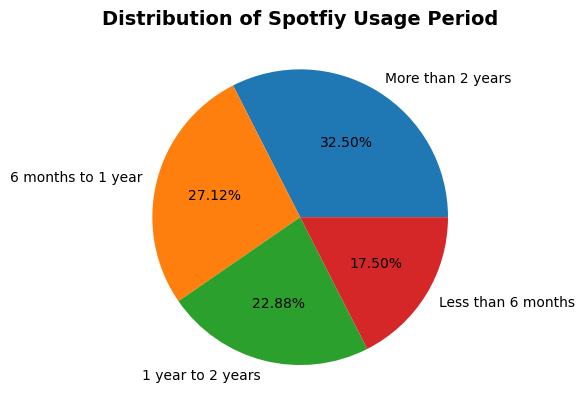

In [76]:
fig, ax = plt.subplots()
ax.pie(df['spotify_usage_period'].value_counts(), labels = df['spotify_usage_period'].unique(), autopct='%.2f%%')

plt.title('Distribution of Spotfiy Usage Period', fontsize=14, fontweight='bold')
plt.show()

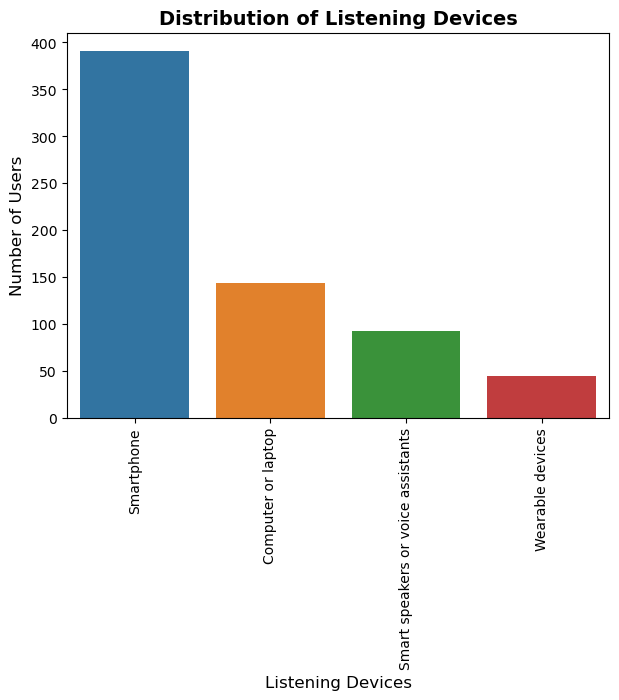

In [77]:
listen_device_count = device['devices'].value_counts()

plt.figure(figsize=(7,5))
ax = sns.barplot(x=listen_device_count.index, y=listen_device_count.values, palette='tab10')

plt.title('Distribution of Listening Devices', fontsize=14, fontweight='bold')
plt.xlabel('Listening Devices', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=90)

plt.show()

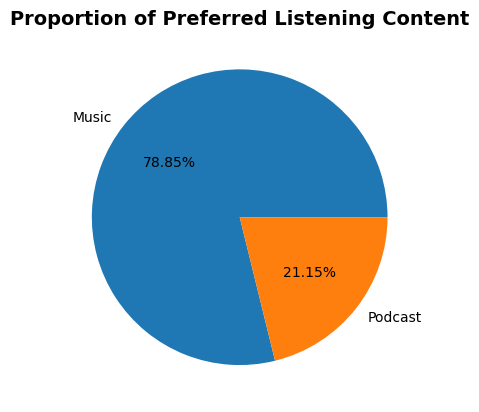

In [78]:
content_count = df['preferred_listening_content'].value_counts()

fig, ax = plt.subplots()
ax.pie(content_count.values, labels = content_count.index, autopct='%.2f%%')

plt.title('Proportion of Preferred Listening Content', fontsize=14, fontweight='bold')
plt.show()

Key Findings:
1. Most users have been using Spotify for more than two years, and the proportions across different usage periods are relatively similar.
2. Around 400 users primarily use their smartphones to listen to Spotify.
3. Approximately 78.9% of users prefer listening to music on Spotify.

## 2.3 Music Preference Analysis

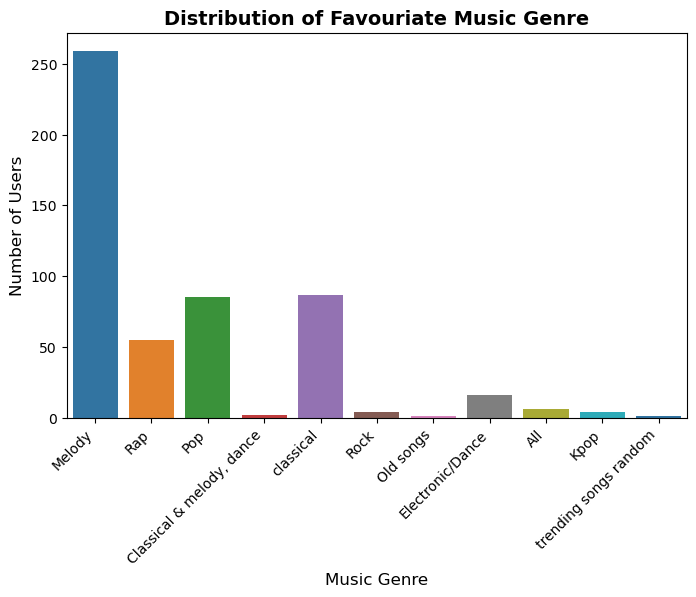

In [79]:
music_genre_count = df['fav_music_genre'].value_counts(normalize=True)

plt.figure(figsize=(8,5))

ax = sns.countplot(x='fav_music_genre', data=df, palette='tab10')
plt.title('Distribution of Favouriate Music Genre', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Music Genre', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()

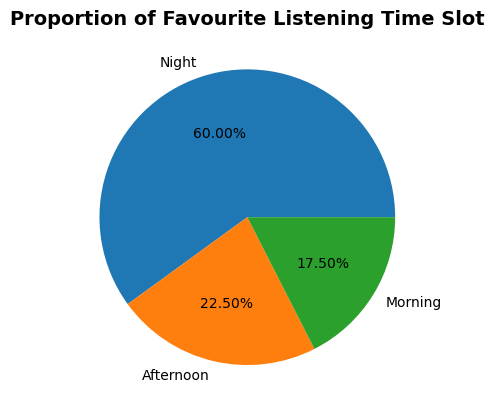

In [80]:
fig, ax = plt.subplots()
ax.pie(df['music_time_slot'].value_counts(), labels = df['music_time_slot'].unique(), autopct='%.2f%%')

plt.title('Proportion of Favourite Listening Time Slot', fontsize=14, fontweight='bold')
plt.show()

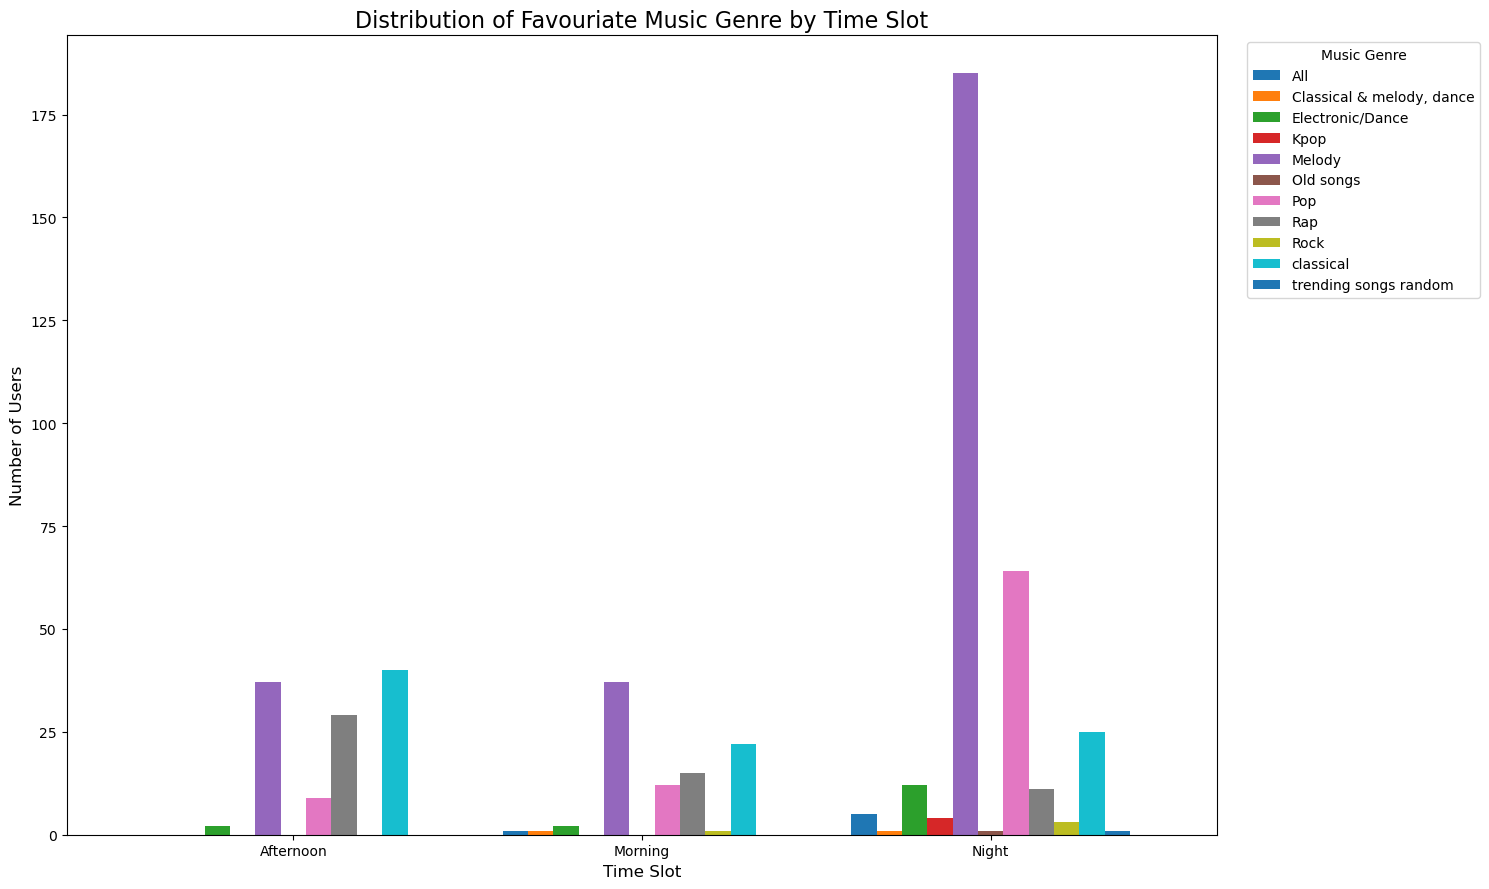

In [81]:
ct = pd.crosstab(df['fav_music_genre'], df['music_time_slot'])
ct_transposed = ct.T

ct_transposed.plot(kind='bar', 
                   figsize=(15, 9),
                   width=0.8)

plt.title('Distribution of Favouriate Music Genre by Time Slot', fontsize=16)
plt.xlabel('Time Slot', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

plt.xticks(rotation=0) 
plt.legend(title='Music Genre', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

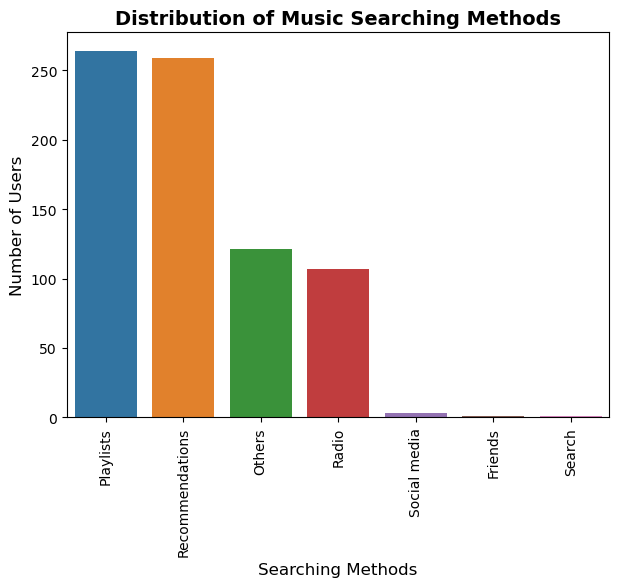

In [82]:
music_search = search_method['search'].value_counts()

plt.figure(figsize=(7,5))
ax = sns.barplot(x=music_search.index, y=music_search.values, palette='tab10')

plt.title('Distribution of Music Searching Methods', fontsize=14, fontweight='bold')
plt.xlabel('Searching Methods', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=90)

plt.show()

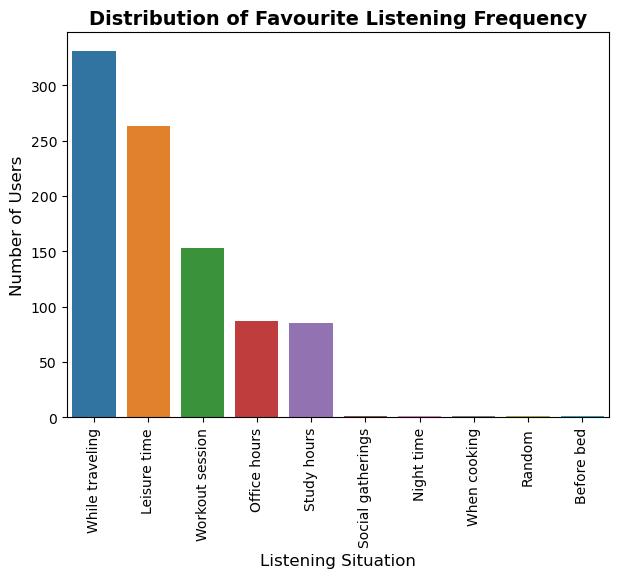

In [83]:
music_listen_freq = listen_freq['lis_freq'].value_counts()

plt.figure(figsize=(7,5))
ax = sns.barplot(x=music_listen_freq.index, y=music_listen_freq.values, palette='tab10')

plt.title('Distribution of Favourite Listening Frequency', fontsize=14, fontweight='bold')
plt.xlabel('Listening Situation', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=90)

plt.show()

---- Table: Music Recommendation Rating
music_recc_rating
3    0.3654
4    0.3346
5    0.1654
2    0.1077
1    0.0269
Name: proportion, dtype: float64


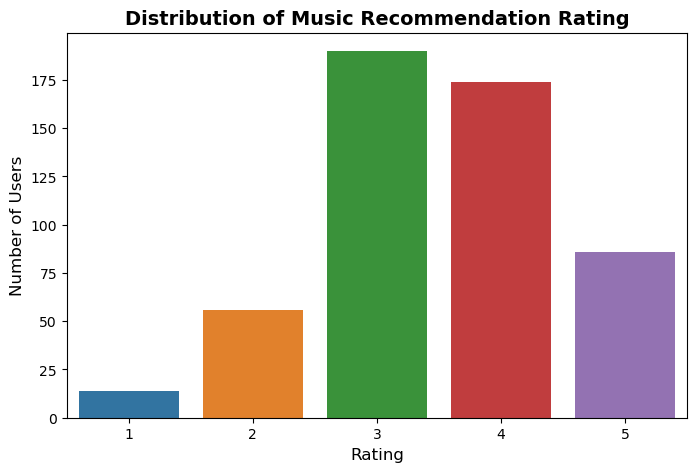

In [84]:
rating_count = df['music_recc_rating'].value_counts(normalize=True).round(4)
print("---- Table: Music Recommendation Rating")
print(rating_count)

plt.figure(figsize=(8,5))

ax = sns.countplot(x='music_recc_rating', data=df)
plt.title('Distribution of Music Recommendation Rating', fontsize=14, fontweight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()

Key Findings:
1. Melody is the most preferred music genre among all users.
2. Most users prefer listening to music while training or at night.
3. Nearly half of users are moderately satisfied with Spotify’s music recommendations, corresponding to ratings between 3 and 4.

## 2.4 Podcast Preference Analysis

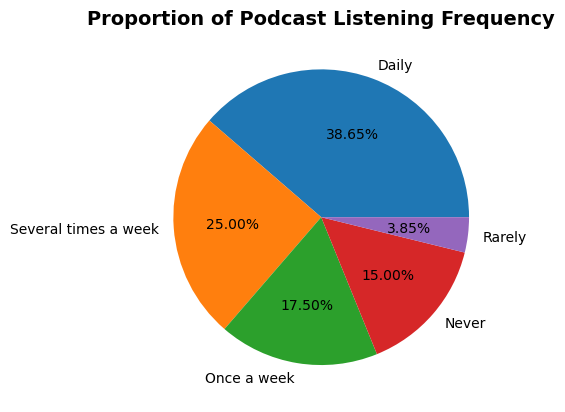

In [85]:
fig, ax = plt.subplots()
ax.pie(df['pod_lis_frequency'].value_counts(), labels = df['pod_lis_frequency'].unique(), autopct='%.2f%%')

plt.title('Proportion of Podcast Listening Frequency', fontsize=14, fontweight='bold')
plt.show()

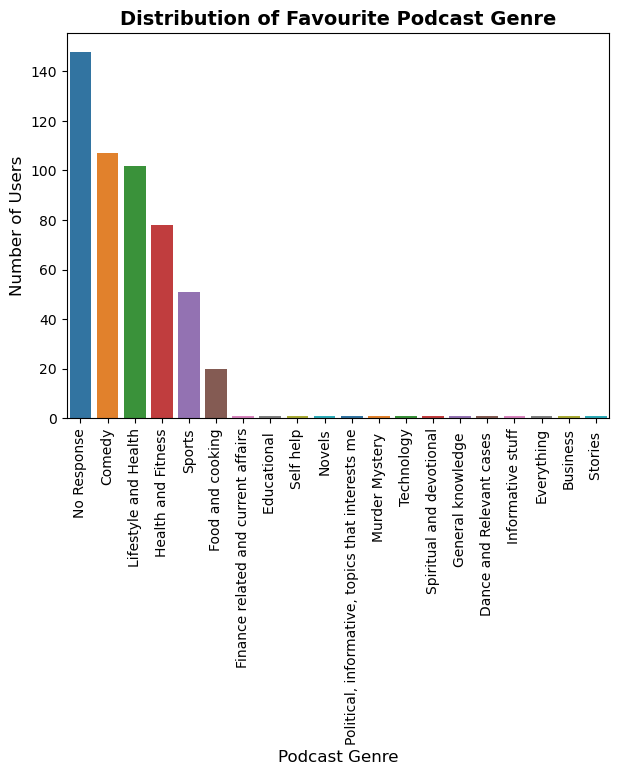

In [86]:
pod_genre_count = df['fav_pod_genre'].value_counts()

plt.figure(figsize=(7,5))
ax = sns.barplot(x=pod_genre_count.index, y=pod_genre_count.values, palette='tab10')

plt.title('Distribution of Favourite Podcast Genre', fontsize=14, fontweight='bold')
plt.xlabel('Podcast Genre', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(rotation=90)

plt.show()

preffered_pod_duration  Both  Longer  No Response  Shorter
preffered_pod_format                                      
Conversational            32      15            1       57
Educational               14       7            1       27
Interview                 22      26            3       23
No Response                5       1          118       16
Story telling             44      34            6       68


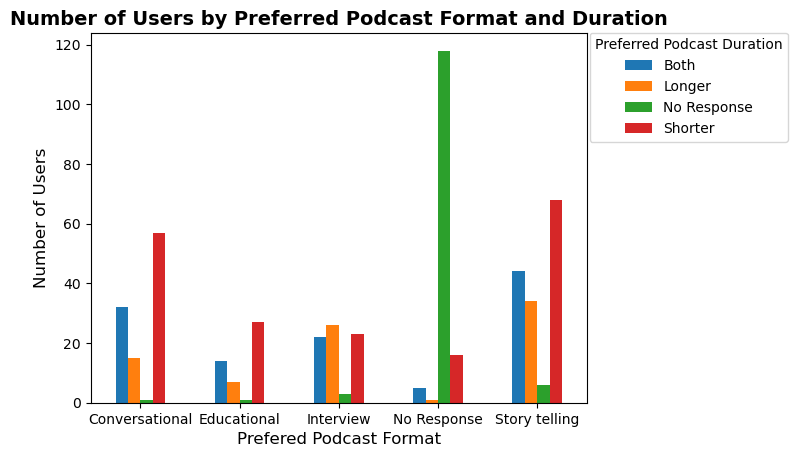

In [87]:
ct = pd.crosstab(df['preffered_pod_format'], df['preffered_pod_duration'])
print(ct)

ax = ct.plot(kind='bar')

plt.title("Number of Users by Preferred Podcast Format and Duration", fontsize=14, fontweight='bold')
plt.xlabel('Prefered Podcast Format', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.legend(title='Preferred Podcast Duration', bbox_to_anchor=(1.42, 1.02) ,loc='upper right')
plt.xticks(rotation=0)
plt.show()

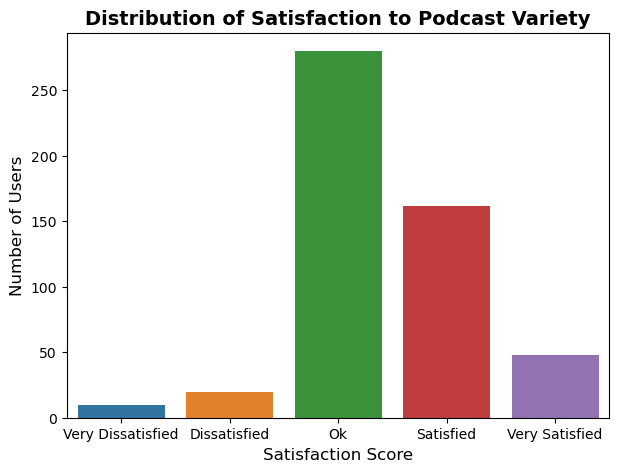

In [88]:
score_order = ['Very Dissatisfied', 'Dissatisfied', 'Ok', 'Satisfied', 'Very Satisfied']
satisfaction_count = df['pod_variety_satisfaction'].value_counts().reindex(score_order)

plt.figure(figsize=(7,5))
ax = sns.barplot(x=satisfaction_count.index, y=satisfaction_count.values)

plt.title('Distribution of Satisfaction to Podcast Variety', fontsize=14, fontweight='bold')
plt.xlabel('Satisfaction Score', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()

Key Findings:
1. Most users prefer to listen to podcasts daily.
2. The most popular podcast genre is comedy.
3. Around 30% users prefer to listen to shorter and story-telling podcasts.
4. Appromixately 85% users moderately satisify the variety of podcasts.

## 2.5 Target Variable: Premium Willingness Overview

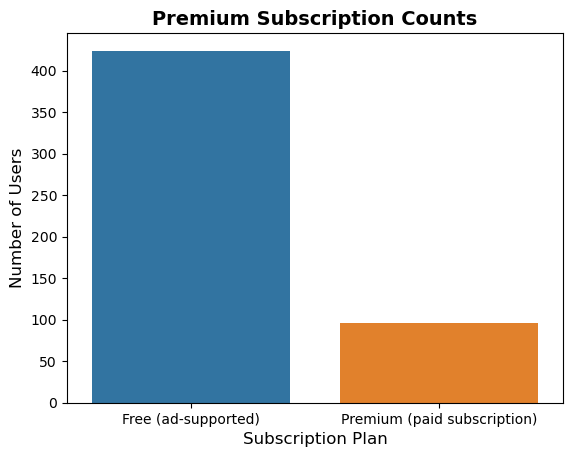

In [89]:
ax = sns.countplot(x='spotify_subscription_plan', data=df)

plt.title('Premium Subscription Counts', fontsize=14, fontweight='bold')
plt.xlabel('Subscription Plan', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.show()

--- Cross Table: Current Subcription Plan vs. Percentage of Premium Willingness ---
premium_sub_willingness             No        Yes
spotify_subscription_plan                        
Free (ad-supported)          73.113208  26.886792
Premium (paid subscription)  25.000000  75.000000


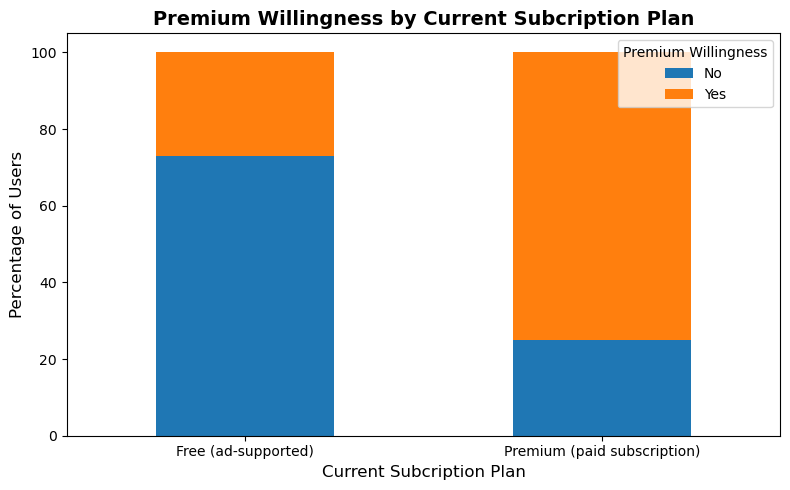

In [90]:
ct = pd.crosstab(df['spotify_subscription_plan'], df['premium_sub_willingness'], normalize='index') * 100
print("--- Cross Table: Current Subcription Plan vs. Percentage of Premium Willingness ---")
print(ct)

ax = ct.plot(kind='bar', stacked=True, figsize=(8,5))

plt.title('Premium Willingness by Current Subcription Plan', fontsize=14, fontweight='bold')
plt.xlabel('Current Subcription Plan', fontsize=12)
plt.ylabel('Percentage of Users', fontsize=12)
plt.legend(title='Premium Willingness', loc='upper right')
plt.xticks(rotation=0)


plt.tight_layout()
plt.show()

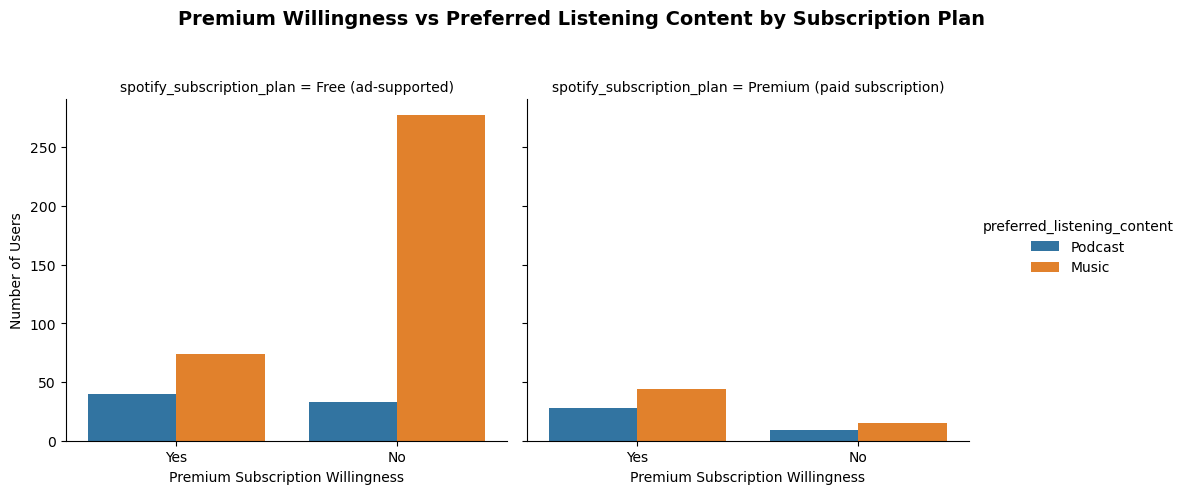

In [91]:
g = sns.catplot(
    data=df,
    x='premium_sub_willingness',
    hue='preferred_listening_content',
    col='spotify_subscription_plan',
    kind='count',           
    palette='tab10',
)

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Premium Willingness vs Preferred Listening Content by Subscription Plan', fontsize=14, fontweight='bold')
g.set_axis_labels('Premium Subscription Willingness', 'Number of Users')

plt.show()

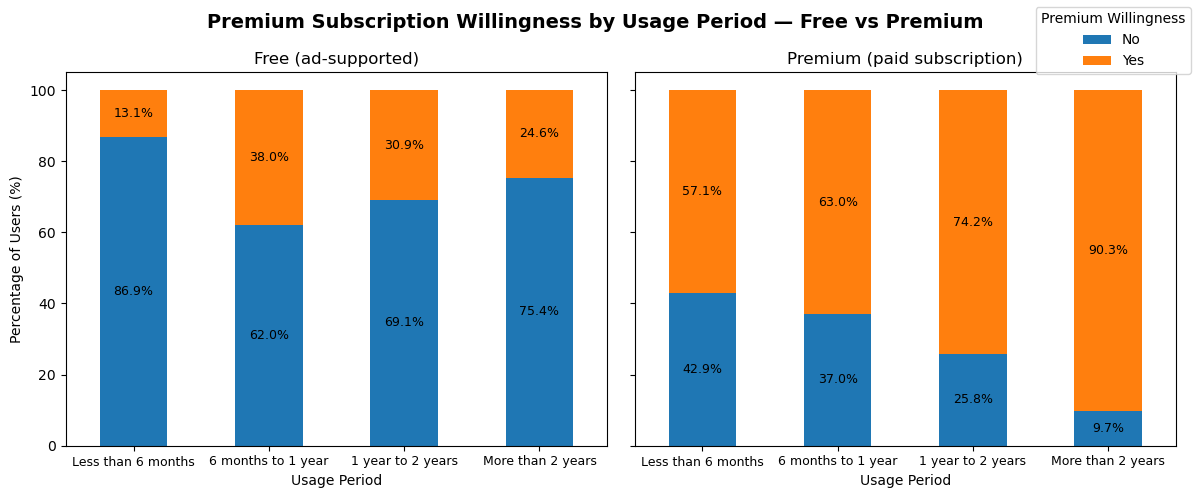

In [92]:
order = ['Less than 6 months', '6 months to 1 year', '1 year to 2 years', 'More than 2 years']
ct = pd.crosstab([df['spotify_subscription_plan'], df['spotify_usage_period']], df['premium_sub_willingness'])
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100 
ct_pct = ct_pct.reindex(order, level=1)

plans = ['Free (ad-supported)', 'Premium (paid subscription)']
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, plan in enumerate(plans):
    sub = ct_pct.loc[plan].reindex(order).fillna(0)      
    cols = [c for c in ['No','Yes'] if c in sub.columns]
    ax = axes[i]
    sub[cols].plot(kind='bar', stacked=True, ax=ax, legend=False)

    ax.set_title(plan)
    ax.set_xlabel('Usage Period')
    ax.set_ylabel('Percentage of Users (%)' if i == 0 else '')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=9)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='center', color='black', fontsize=9)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Premium Willingness', loc='upper right')

fig.suptitle('Premium Subscription Willingness by Usage Period — Free vs Premium', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

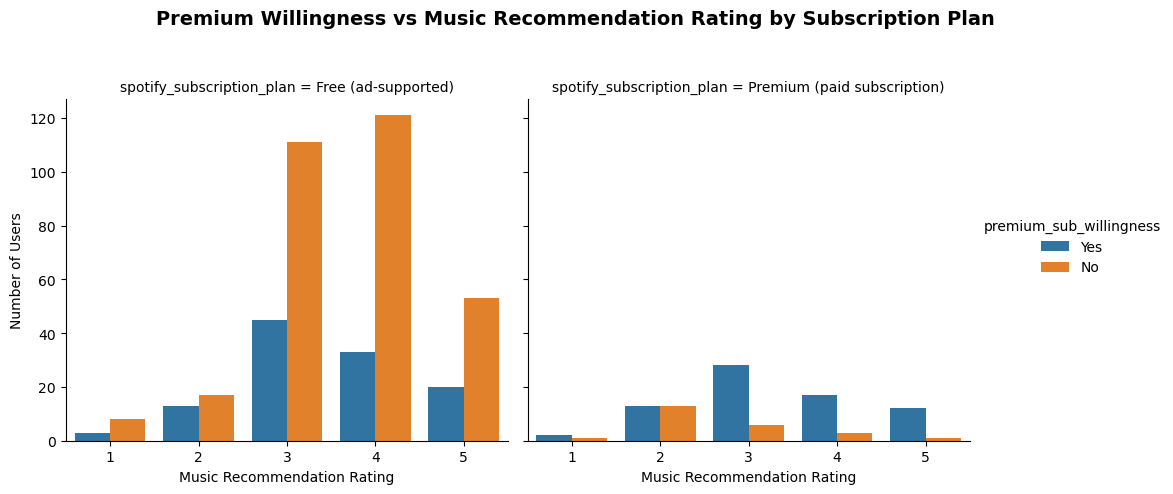

In [93]:
g = sns.catplot(
    data=df,
    x='music_recc_rating',
    hue='premium_sub_willingness',
    col='spotify_subscription_plan',
    kind='count',           
    palette='tab10',
)

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Premium Willingness vs Music Recommendation Rating by Subscription Plan', fontsize=14, fontweight='bold')
g.set_axis_labels('Music Recommendation Rating', 'Number of Users')

plt.show()

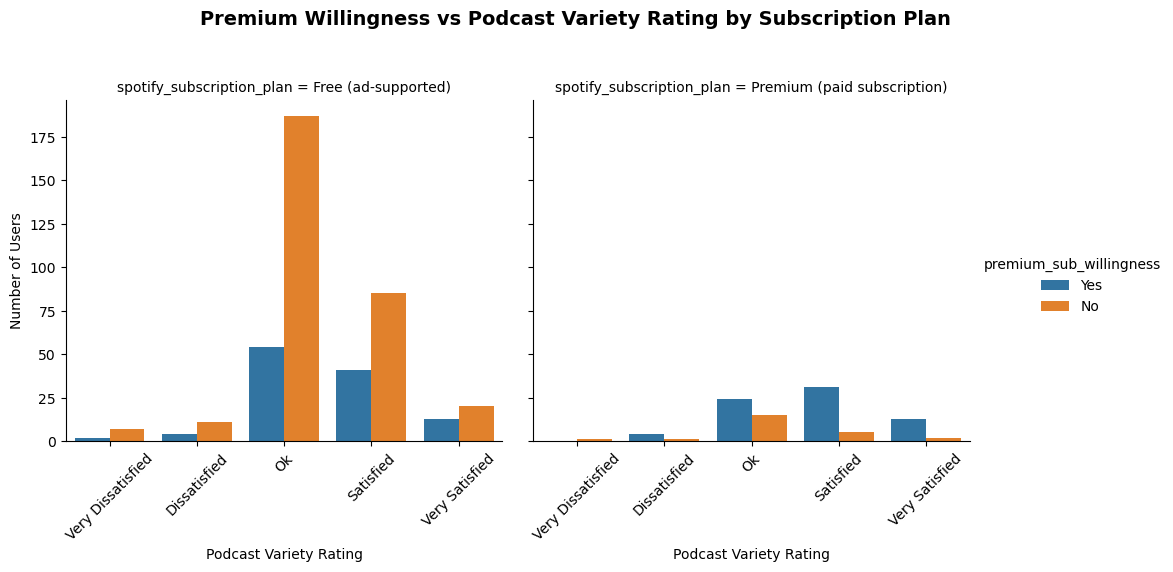

In [94]:
order_list = ['Very Dissatisfied', 'Dissatisfied', 'Ok', 'Satisfied', 'Very Satisfied']

g = sns.catplot(
    data=df,
    x='pod_variety_satisfaction',
    hue='premium_sub_willingness',
    col='spotify_subscription_plan',
    order=order_list, 
    kind='count',           
    palette='tab10',
)

g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Premium Willingness vs Podcast Variety Rating by Subscription Plan', fontsize=14, fontweight='bold')
g.set_axis_labels('Podcast Variety Rating', 'Number of Users')
g.set_xticklabels(rotation=45)

plt.show()

**Following Analysis & Conclusion**

Based on the survey results, around 73% of free users are unwilling to subscribe to the Premium plan, and longer usage does not appear to increase their interest in upgrading. This indicates that extended platform exposure alone is not enough to drive conversion, making it valuable to explore what behavioural or preference factors influence subscription willingness.

For Premium users, most remain willing to continue their subscription, but those with less than one year of usage may be at higher risk of churn. Understanding why early-stage subscribers leave is critical to improving retention and optimising customer lifetime value.

Therefore, the following analysis will be divided into two parts:
- Free users: focusing on conversion analysis to identify significant behavioural or demographic factors affecting upgrade intention;
- Premium users: conducting churn analysis to detect potential at-risk groups and understand key reasons for attrition.

These insights will help inform targeted marketing and retention strategies for Spotify’s different user segments.

# Section 3. Free Users Upgrade Analysis

This section investigates **factors that influence Free users' willingness to upgrade** to a Premium plan, focusing on their listening behaviour, preferred content type, usage duration, and genre preferences.

In [95]:
# Filter free users
df_free = df_stats[df_stats['spotify_subscription_plan'] == 'Free (ad-supported)']

# Convert the target variable into binary format: 1 = willing to upgrade, 0 = not willing
df_free['premium_sub_willingness'] = np.where(df_free['premium_sub_willingness'] == 'Yes', 1, 0)

# Drop redundant column
df_free = df_free.drop(['spotify_subscription_plan'], axis=1)

print(f"Free users: {len(df_free)} / Total: {len(df)}")
df_free.head()

Free users: 424 / Total: 520


C:\Users\jeffs\AppData\Local\Temp\ipykernel_22964\2413530751.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_free['premium_sub_willingness'] = np.where(df_free['premium_sub_willingness'] == 'Yes', 1, 0)


,Age,Gender,spotify_usage_period,spotify_listening_device,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,...,When cooking,While traveling,Workout session,Friends,Others,Playlists,Radio,Recommendations,Search,Social media
0,20-35,Female,More than 2 years,Smart speakers or voice assistants,1,Family Plan - GBP 19.99/month,Podcast,Melody,Night,Sadness or melancholy,...,0,0,0,0,0,1,0,0,0,0
1,12-20,Male,More than 2 years,Computer or laptop,1,Individual Plan - GBP 11.99/ month,Podcast,Rap,Afternoon,Social gatherings or parties,...,0,0,1,0,0,1,0,0,0,0
2,35-60,Others,6 months to 1 year,Smart speakers or voice assistants,1,Student Plan - GBP 5.99/month,Podcast,Pop,Night,Relaxation and stress relief,...,0,1,0,0,0,1,0,0,0,0
3,20-35,Female,1 year to 2 years,"Smartphone, Smart speakers or voice assistants",0,No Response,Music,Melody,Night,"Relaxation and stress relief, Social gathering...",...,0,0,1,0,0,1,0,1,0,0
4,20-35,Female,1 year to 2 years,Smartphone,0,No Response,Music,Melody,Night,Relaxation and stress relief,...,0,0,0,0,0,1,0,1,0,0


## 3.1 Conversion Analysis by Demographic Variables and Users Behaviours

This section evaluates how Free users’ **devices**, **preferred Premium plan**, **preferred listening content × age**, and **usage duration** relate to their willingness to upgrade.

In [96]:
# Start from a clean copy and create a stable 'user_id'
df_with_id = df_free.reset_index().rename(columns={'index': 'user_id'})

# Explode comma-separated devices
df_exploded_device = df_with_id.assign(
    devices = df_free['spotify_listening_device'].str.split(',')
).explode('devices')

# Clean device labels
df_exploded_device['devices'] = df_exploded_device['devices'].str.strip().str.capitalize()
df_exploded_device = df_exploded_device[df_exploded_device['devices'] != '']

# Count unique users per device
total_listen_devices_per_freq = df_exploded_device.groupby('devices')['user_id'].nunique()
willing_upgrade_listen_per_freq = df_exploded_device[df_exploded_device['premium_sub_willingness'] == 1].groupby('devices')['user_id'].nunique()

# --- The rest of the code remains the same ---
device_freq_stats = pd.DataFrame({
    'total_listeners': total_listen_devices_per_freq,
    'willing_listeners': willing_upgrade_listen_per_freq
})

device_freq_stats['willing_listeners'] = device_freq_stats['willing_listeners'].fillna(0).astype(int)
device_freq_stats['conversion_rate'] = device_freq_stats['willing_listeners'] / device_freq_stats['total_listeners']
device_freq_stats = device_freq_stats.sort_values(by='conversion_rate', ascending=False).reset_index()

print("Listening Devices Conversion Stats:")
print(device_freq_stats)

Listening Devices Conversion Stats:
                              devices  total_listeners  willing_listeners  \
0                    Wearable devices               28                  8   
1                          Smartphone              300                 84   
2                  Computer or laptop               76                 19   
3  Smart speakers or voice assistants               41                  8   

   conversion_rate  
0         0.285714  
1         0.280000  
2         0.250000  
3         0.195122  


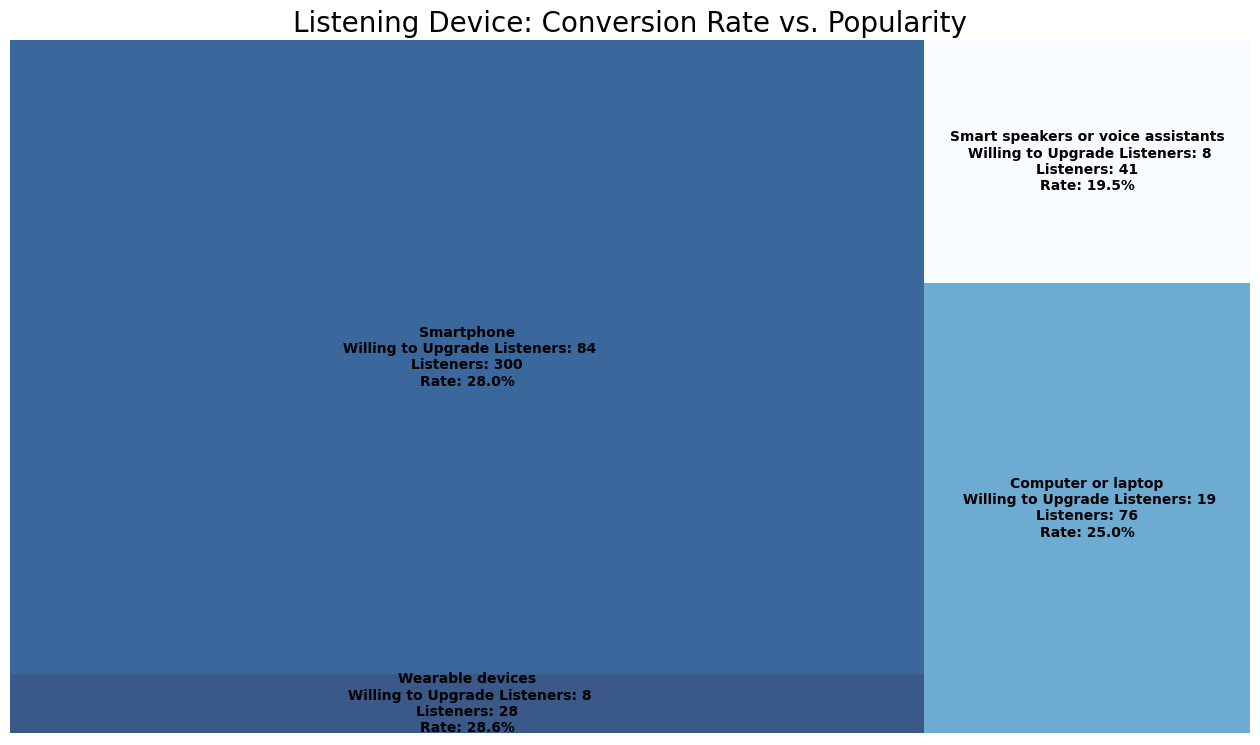

In [97]:
# Treemap
device_freq_stats_plot = device_freq_stats[device_freq_stats['willing_listeners'] > 1]

plt.figure(figsize=(16, 9))

cmap = plt.cm.Blues 
norm = plt.Normalize(vmin=device_freq_stats_plot['conversion_rate'].min(), vmax=device_freq_stats_plot['conversion_rate'].max())
colors = [cmap(norm(value)) for value in device_freq_stats_plot['conversion_rate']]


labels = [f"{row.devices}\n Willing to Upgrade Listeners: {row.willing_listeners}\nListeners: {row.total_listeners}\nRate: {row.conversion_rate:.1%}"
          for index, row in device_freq_stats_plot.iterrows()]

squarify.plot(sizes=device_freq_stats_plot['total_listeners'],
              label=labels,
              color=colors,
              alpha=0.8,
              text_kwargs={'fontsize': 10, 'color': 'black', 'fontweight': 'bold'})

plt.title('Listening Device: Conversion Rate vs. Popularity', fontsize=20)
plt.axis('off')
plt.show()

Table: Conversion Rate by Premium Plan:
premium_sub_willingness                  0       1
preffered_premium_plan                            
Student Plan - GBP 5.99/month       0.7059  0.2941
Individual Plan - GBP 11.99/ month  0.4068  0.5932
Duo Plan - GBP 16.99/month          0.4138  0.5862
Family Plan - GBP 19.99/month       0.2727  0.7273
No Response                         0.9800  0.0200


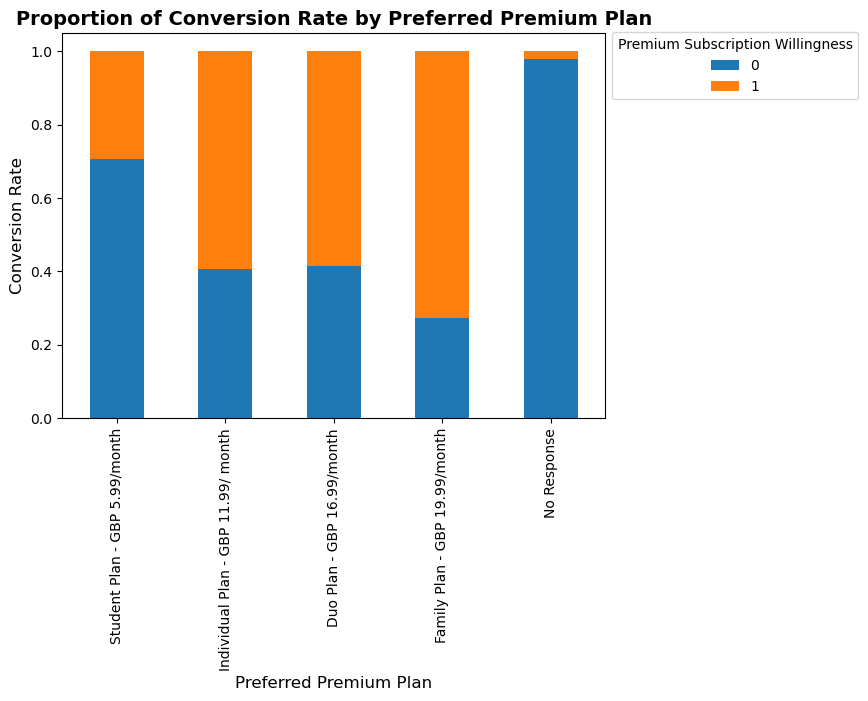

In [98]:
premium_plan_conversion_rate = df_free.groupby('preffered_premium_plan')['premium_sub_willingness'].value_counts(normalize=True).round(4)
premium_plan_conversion_table = premium_plan_conversion_rate.unstack()

plan_order = ['Student Plan - GBP 5.99/month', 'Individual Plan - GBP 11.99/ month', 'Duo Plan - GBP 16.99/month', 'Family Plan - GBP 19.99/month', 'No Response']
premium_plan_conversion_table = premium_plan_conversion_table.reindex(plan_order)

print("Table: Conversion Rate by Premium Plan:")
print(premium_plan_conversion_table)

ax = premium_plan_conversion_table.plot(kind='bar', stacked=True, figsize=(7, 5))

plt.title("Proportion of Conversion Rate by Preferred Premium Plan", fontsize=14, fontweight='bold')
plt.xlabel("Preferred Premium Plan", fontsize=12)
plt.ylabel("Conversion Rate", fontsize=12)
plt.legend(title="Premium Subscription Willingness", bbox_to_anchor=(1.48, 1.02),loc='upper right')
plt.show()

Music vs. Podcast - Premium Plan Coversion Rate by Age Group：
       Music Listeners  Podcast Listeners
Age                                      
6-12          0.000000           0.000000
12-20         0.241379           0.700000
20-35         0.208333           0.500000
35-60         0.250000           0.444444
60+           0.000000           0.000000


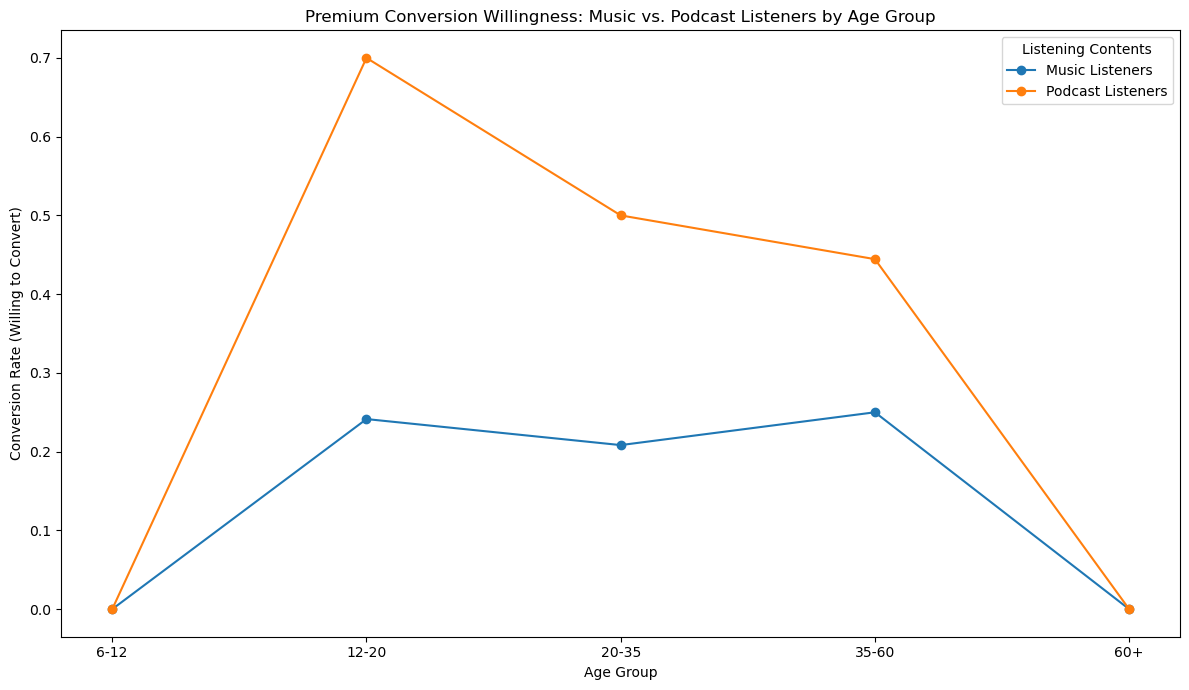

In [99]:
# Identify listener types (non-exclusive)
is_music_listener = df_free['preferred_listening_content'].str.contains('Music', case=False, na=False)
is_podcast_listener = df_free['preferred_listening_content'].str.contains('Podcast', case=False, na=False)

# Calculate conversion rates by age group for each content type
music_conversion_rates = df_free[is_music_listener].groupby('Age')['premium_sub_willingness'].value_counts(normalize=True)
music_conversion_table = music_conversion_rates.unstack()
music_willing_to_convert = music_conversion_table.get(1)

podcast_conversion_rates = df_free[is_podcast_listener].groupby('Age')['premium_sub_willingness'].value_counts(normalize=True)
podcast_conversion_table = podcast_conversion_rates.unstack()
podcast_willing_to_convert = podcast_conversion_table.get(1)

# Use pd.DataFrame to merge the two Series into a single DataFrame for comparison and plotting
comparison_df = pd.DataFrame({
    'Music Listeners': music_willing_to_convert,
    'Podcast Listeners': podcast_willing_to_convert
})

# Fill potential NaN values with 0 (e.g., if an age group only has one type of listener)
comparison_df = comparison_df.fillna(0)

age_order = ['6-12', '12-20', '20-35', '35-60', '60+']
comparison_df_sorted = comparison_df.reindex(age_order)

print("Music vs. Podcast - Premium Plan Coversion Rate by Age Group：")
print(comparison_df_sorted)


fig, ax = plt.subplots(figsize=(12, 7))

comparison_df_sorted.plot(kind='line', marker='o', ax=ax)

ax.set_title('Premium Conversion Willingness: Music vs. Podcast Listeners by Age Group')
ax.set_xlabel('Age Group')
ax.set_ylabel('Conversion Rate (Willing to Convert)')

ax.set_xticks(range(len(comparison_df_sorted.index)))
ax.set_xticklabels(comparison_df_sorted.index)

ax.legend(title='Listening Contents') 

plt.tight_layout() 
plt.show()

In [100]:
usage_order = ['Less than 6 months', '6 months to 1 year', '1 year to 2 years', 'More than 2 years']

# --- Prepare data for the first plot (left): Conversion Rate by Usage Period for Music Listeners ---
music_usage_conversion_rate = df_free[is_music_listener].groupby('spotify_usage_period')['premium_sub_willingness'].value_counts(normalize=True).round(4)
music_usage_conversion_table = music_usage_conversion_rate.unstack()

music_usage_conversion_table = music_usage_conversion_table.reindex(usage_order)

print("Table: Conversion Rates by Usage Period of Music Listeners")
print(music_usage_conversion_table)

# --- Prepare data for the second plot (right): Conversion Rate by Usage Period for Podcast Listeners ---
podcast_usage_conversion_rate = df_free[is_podcast_listener].groupby('spotify_usage_period')['premium_sub_willingness'].value_counts(normalize=True).round(4)
podcast_usage_conversion_table = podcast_usage_conversion_rate.unstack()

podcast_usage_conversion_table = podcast_usage_conversion_table.reindex(usage_order)

print("\n")
print("Table: Conversion Rates by Usage Period of Podcast Listeners")
print(podcast_usage_conversion_table)

Table: Conversion Rates by Usage Period of Music Listeners
premium_sub_willingness       0       1
spotify_usage_period                   
Less than 6 months       0.8784  0.1216
6 months to 1 year       0.7097  0.2903
1 year to 2 years        0.8046  0.1954
More than 2 years        0.7656  0.2344


Table: Conversion Rates by Usage Period of Podcast Listeners
premium_sub_willingness       0       1
spotify_usage_period                   
Less than 6 months       0.8000  0.2000
6 months to 1 year       0.4333  0.5667
1 year to 2 years        0.2609  0.7391
More than 2 years        0.6000  0.4000


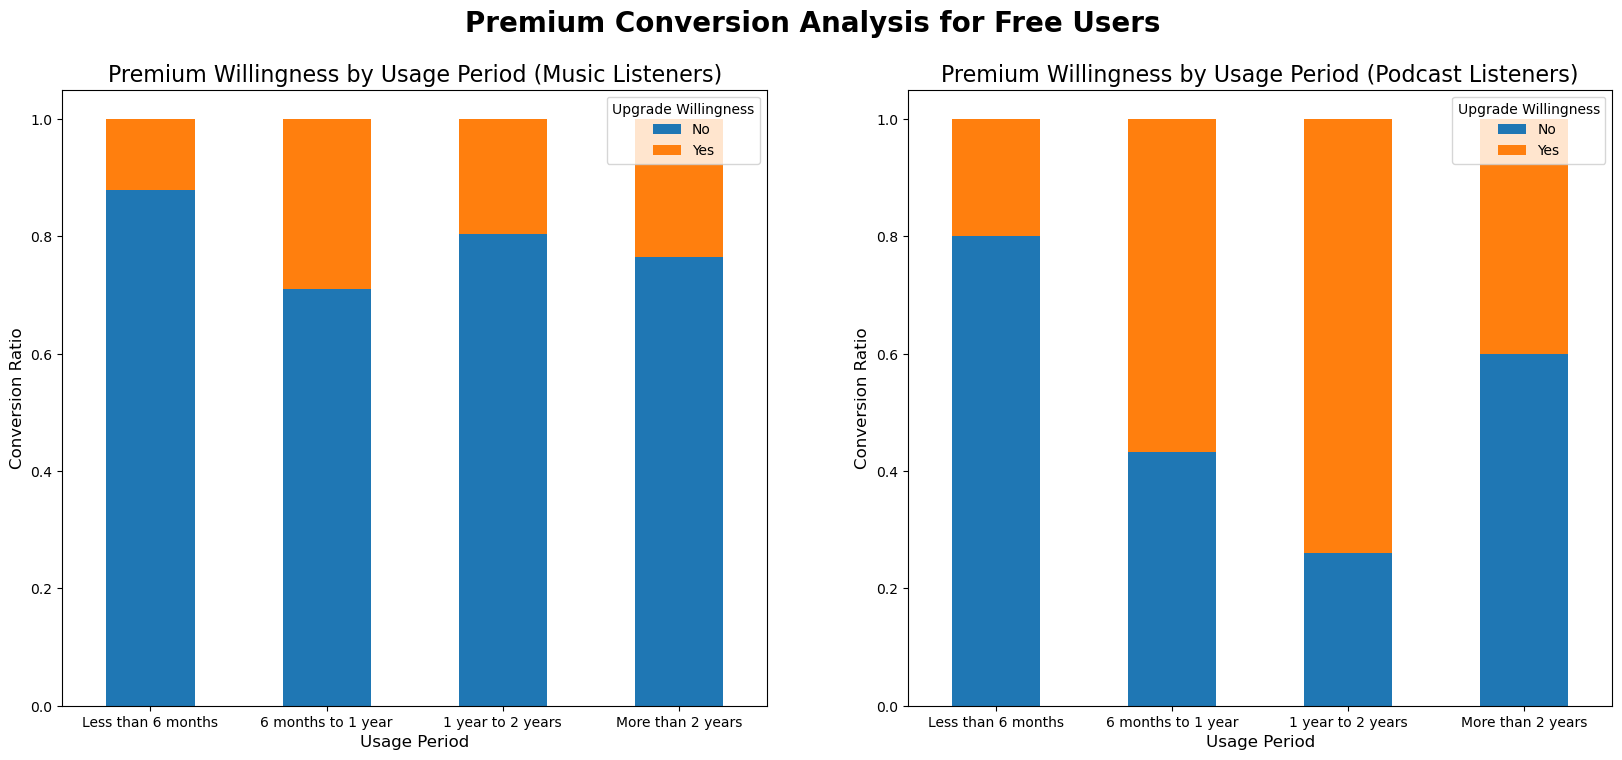

In [101]:
# Create a 1x2 subplot grid
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Draw the stacked bar chart on the first subplot (ax1)
ax1 = music_usage_conversion_table.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_title('Premium Willingness by Usage Period (Music Listeners)', fontsize=16)
ax1.set_xlabel('Usage Period', fontsize=12)
ax1.set_ylabel('Conversion Ratio', fontsize=12)
ax1.tick_params(axis='x', rotation=0)
ax1.legend(title='Upgrade Willingness', labels=['No', 'Yes'])

# Draw the stacked bar chart on the second subplot (ax2) 
ax2 = podcast_usage_conversion_table.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Premium Willingness by Usage Period (Podcast Listeners)', fontsize=16)
ax2.set_xlabel('Usage Period', fontsize=12)
ax2.set_ylabel('Conversion Ratio', fontsize=12)
ax2.tick_params(axis='x', rotation=0)
ax2.legend(title='Upgrade Willingness', labels=['No', 'Yes'])

fig.suptitle('Premium Conversion Analysis for Free Users', fontsize=20, fontweight='bold')
plt.show()

Key Findings:
1. **Device Usage and Conversion:**
There is no significant difference in conversion rates across listening devices. However, users who access Spotify via smartphones or wearable devices show a slightly higher likelihood of upgrading to a Premium plan. This may suggest that on-the-go users value the ad-free or offline features of the paid service.

2. **Pricing Preferences:**
Users tend to prefer higher-tier subscription plans that support multiple users, as these offer a lower cost per user. This implies that price sensitivity remains an important factor in conversion decisions, particularly for shared or family usage. The only exception is the Student Plan, where other factors (e.g., personal affordability or content preference) may play a greater role.

3. **Content Type and Willingness to Upgrade:**
Users who primarily listen to podcasts exhibit a higher willingness to subscribe to the Premium plan. This highlights an opportunity to design marketing strategies targeting podcast-oriented audiences, such as exclusive content or bundled podcast benefits.

4. **Tenure and Engagement Among Podcast Listeners:**
Among podcast listeners, those who have used Spotify for over one to two years demonstrate an increasing tendency to upgrade. This suggests that long-term engagement contributes positively to conversion potential, and retention campaigns could focus on sustaining active listening habits during the first year of user experience.

## 3.2 Conversion Analysis by Preferred Music and Podcast Genre

In the previous analysis, I found that music and podcast listeners differ significantly in their willingness to upgrade to the Premium plan. Therefore, it would be valuable to analyse these two groups separately to identify their **favourite genres and content preferences**, which may help explain their distinct conversion behaviours.

In [102]:
# Filter music listeners
df_music = df_free[is_music_listener].copy()

# Clean and trim genre text
df_music['genre_cleaned'] = df_music['fav_music_genre'].str.strip().str.capitalize()

genre_stats1 = df_music.groupby('genre_cleaned')['premium_sub_willingness'].agg(
    total_listeners='count',
    willing_listeners=lambda x: (x == 1).sum()
).reset_index()
genre_stats1['conversion_rate'] = genre_stats1['willing_listeners'] / genre_stats1['total_listeners']
genre_stats1 = genre_stats1.sort_values(by='conversion_rate', ascending=False)

print("Music Genre Conversion Stats:")
print(genre_stats1)

Music Genre Conversion Stats:
                genre_cleaned  total_listeners  willing_listeners  \
2   Classical & melody, dance                2                  1   
1                   Classical               29                 11   
8                         Rap               16                  6   
5                      Melody              214                 43   
0                         All                5                  1   
3            Electronic/dance               11                  2   
7                         Pop               66                 10   
4                        Kpop                4                  0   
6                   Old songs                1                  0   
9                        Rock                2                  0   
10      Trending songs random                1                  0   

    conversion_rate  
2          0.500000  
1          0.379310  
8          0.375000  
5          0.200935  
0          0.200000  
3        

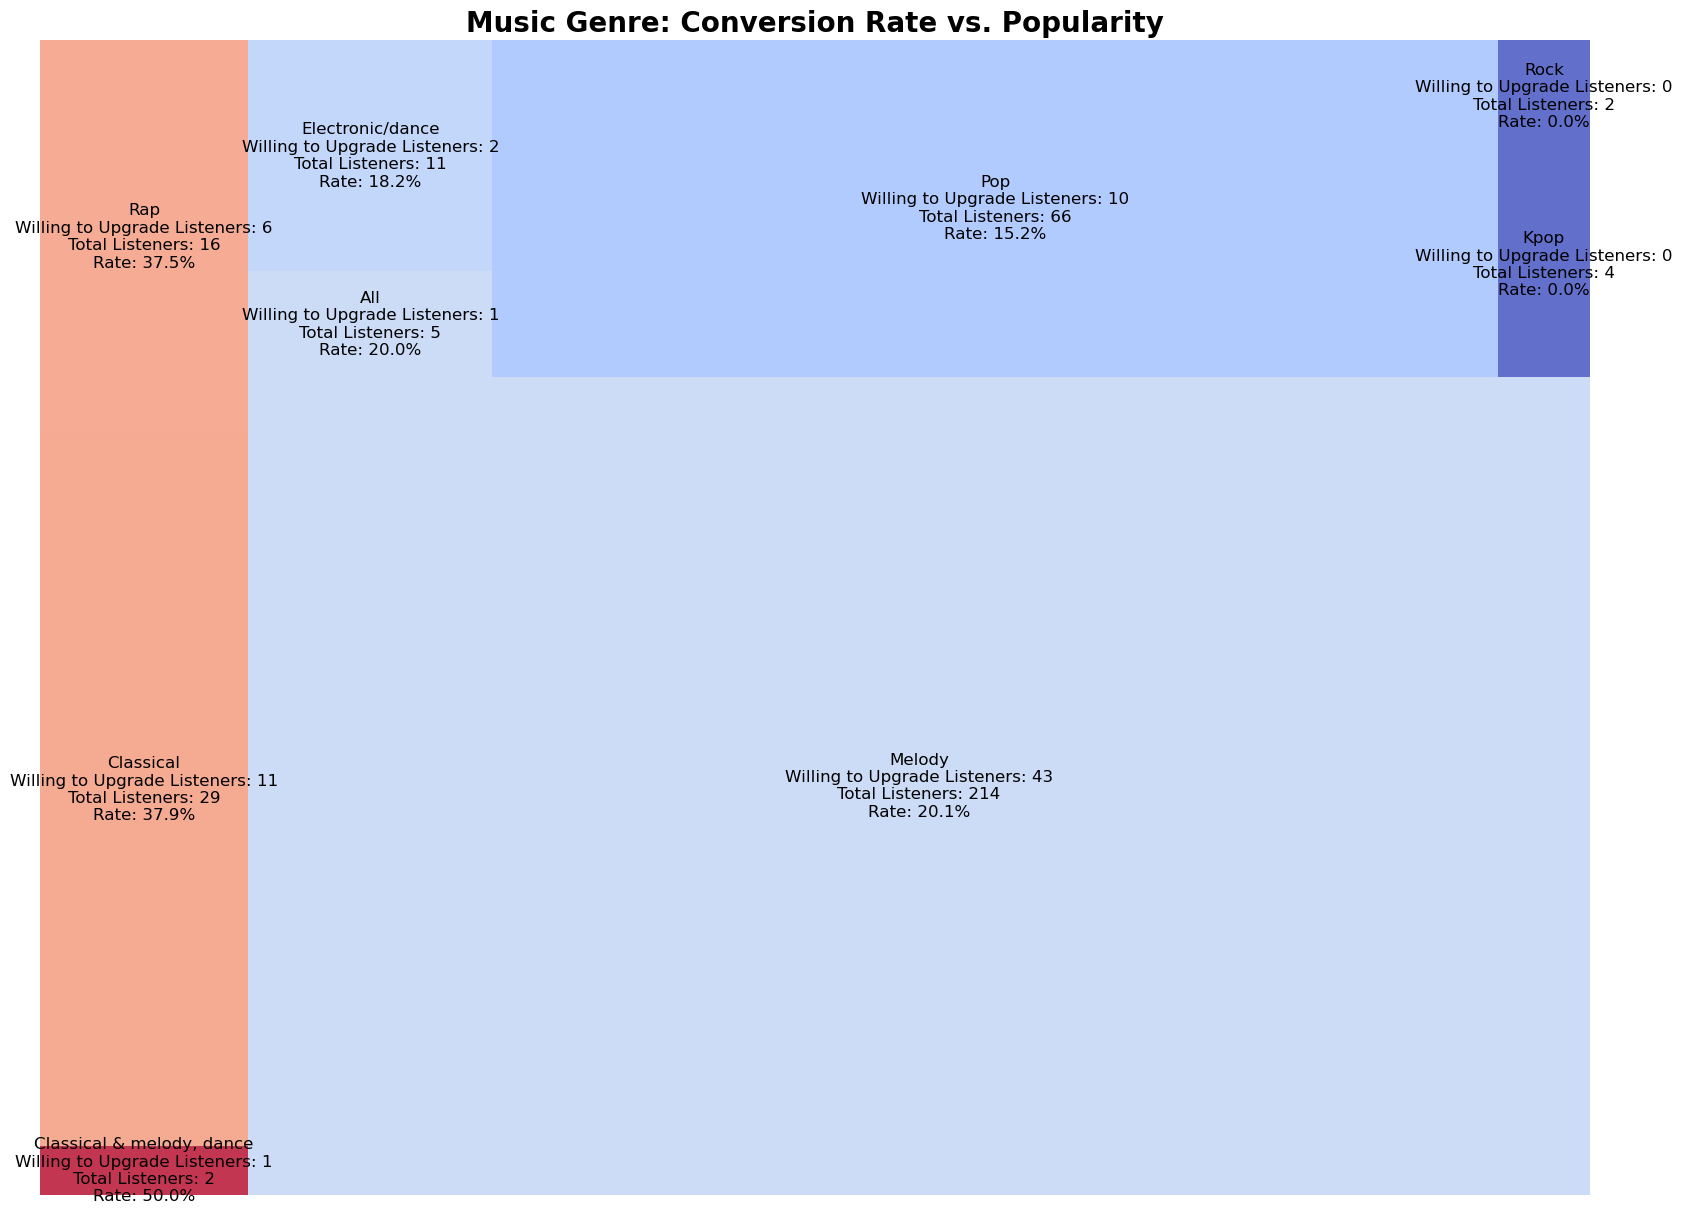

In [103]:
min_total = 2
genre_stats1_plot = genre_stats1[genre_stats1['total_listeners'] >= min_total]

plt.figure(figsize=(20, 15))

# Create a colour mapping — the darker the colour, the higher the conversion rate
cmap = plt.cm.coolwarm 
norm = plt.Normalize(vmin=genre_stats1_plot['conversion_rate'].min(), vmax=genre_stats1_plot['conversion_rate'].max())
colors = [cmap(norm(value)) for value in genre_stats1_plot['conversion_rate']]

# Create labels (Genre \n Willing Listeners \n Total Listeners \n Conversion Rate)
labels = [f"{row.genre_cleaned}\nWilling to Upgrade Listeners: {row.willing_listeners}\nTotal Listeners: {row.total_listeners}\nRate: {row.conversion_rate:.1%}"
          for index, row in genre_stats1_plot.iterrows()]

squarify.plot(sizes=genre_stats1_plot['total_listeners'],
              label=labels,
              color=colors,
              alpha=0.8,
              text_kwargs={'fontsize': 12, 'color': 'black'})

plt.title('Music Genre: Conversion Rate vs. Popularity', fontsize=20, fontweight='bold')
plt.axis('off')
plt.show()

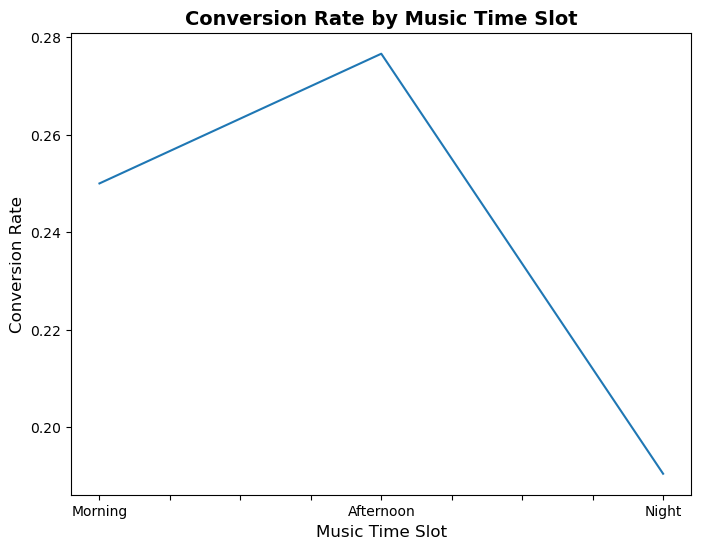

In [104]:
time_slot_order = ['Morning', 'Afternoon', 'Night']

time_slot_stats = df_music.groupby('music_time_slot')['premium_sub_willingness'].value_counts(normalize=True)
time_slot_stats = time_slot_stats.unstack()
time_slot_stats = time_slot_stats.reindex(time_slot_order)
time_slot_stats_convert = time_slot_stats.get(1)

ax = time_slot_stats_convert.plot(kind='line', figsize=(8, 6))

plt.title("Conversion Rate by Music Time Slot", fontsize=14, fontweight='bold')
plt.xlabel('Music Time Slot', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xticks(rotation=0)

plt.show()

In [105]:
# Reset the index to create a 'user_id' column
df_with_id = df_free.reset_index().rename(columns={'index': 'user_id'})

# Explode the data. The 'user_id' will be duplicated for each choice.
df_exploded = df_with_id.assign(
    lis_freq=df_with_id['music_lis_frequency'].str.split(',')
).explode('lis_freq')

# Clean up the new column as before
df_exploded['lis_freq'] = df_exploded['lis_freq'].str.strip().str.capitalize()
df_exploded = df_exploded.dropna(subset=['lis_freq'])
df_exploded = df_exploded[df_exploded['lis_freq'] != '']


total_listeners_per_freq = df_exploded.groupby('lis_freq')['user_id'].nunique()
willing_listeners_per_freq = df_exploded[df_exploded['premium_sub_willingness'] == 1].groupby('lis_freq')['user_id'].nunique()

freq_stats = pd.DataFrame({
    'total_listeners': total_listeners_per_freq,
    'willing_listeners': willing_listeners_per_freq
})

freq_stats['willing_listeners'] = freq_stats['willing_listeners'].fillna(0).astype(int)
freq_stats['conversion_rate'] = freq_stats['willing_listeners'] / freq_stats['total_listeners']
freq_stats = freq_stats.sort_values(by='conversion_rate', ascending=False).reset_index()

print("Music Listening Frequency Conversion Stats:")
print(freq_stats)

Music Listening Frequency Conversion Stats:
            lis_freq  total_listeners  willing_listeners  conversion_rate
0         Before bed                1                  1         1.000000
1         Night time                1                  1         1.000000
2       When cooking                1                  1         1.000000
3        Study hours               58                 26         0.448276
4    Workout session              115                 34         0.295652
5    While traveling              269                 74         0.275093
6       Leisure time              228                 52         0.228070
7       Office hours               69                 15         0.217391
8             Random                1                  0         0.000000
9  Social gatherings                1                  0         0.000000


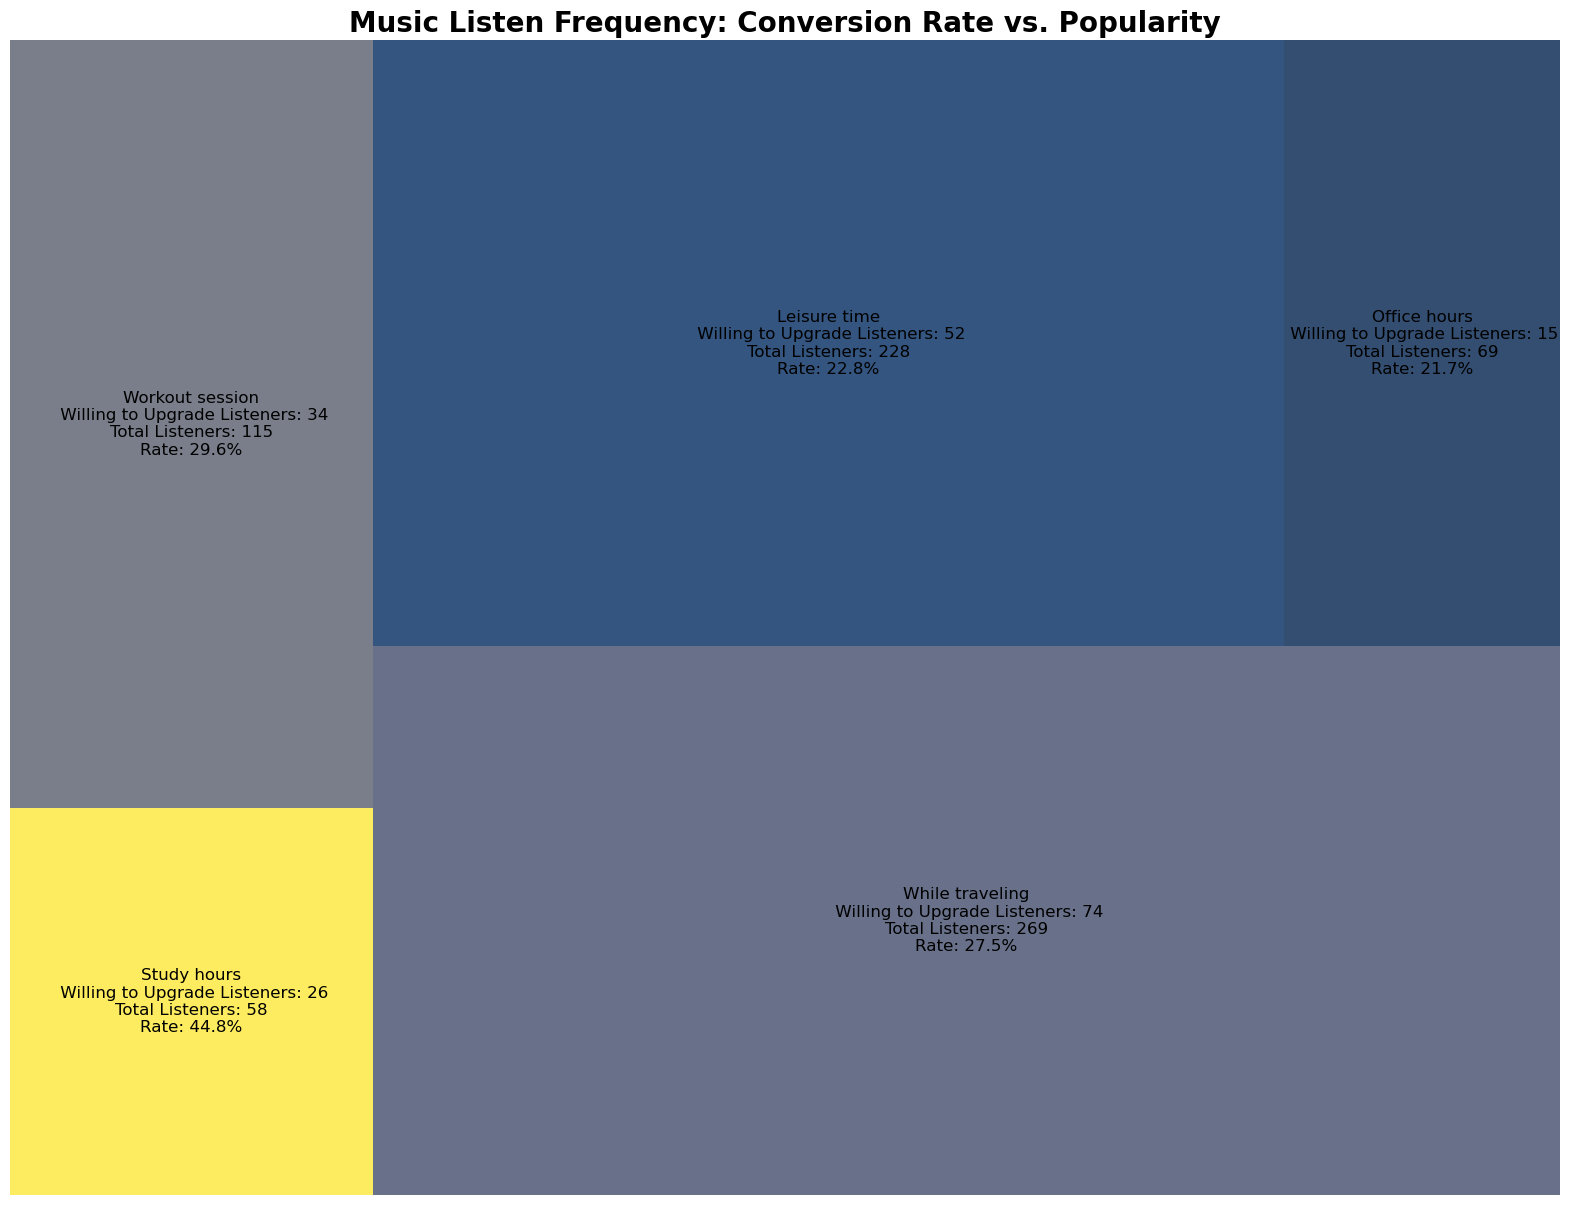

In [106]:
freq_stats_plot = freq_stats[freq_stats['willing_listeners'] >= min_total]

plt.figure(figsize=(20, 15))

cmap = plt.cm.cividis 
norm = plt.Normalize(vmin=freq_stats_plot['conversion_rate'].min(), vmax=freq_stats_plot['conversion_rate'].max())
colors = [cmap(norm(value)) for value in freq_stats_plot['conversion_rate']]

labels = [f"{row.lis_freq}\n Willing to Upgrade Listeners: {row.willing_listeners}\nTotal Listeners: {row.total_listeners}\nRate: {row.conversion_rate:.1%}"
          for index, row in freq_stats_plot.iterrows()]

squarify.plot(sizes=freq_stats_plot['total_listeners'],
              label=labels,
              color=colors,
              alpha=0.8,
              text_kwargs={'fontsize': 12, 'color': 'black'})

plt.title('Music Listen Frequency: Conversion Rate vs. Popularity', fontsize=20, fontweight='bold')
plt.axis('off')
plt.show()

In [107]:
# Filter podcast listeners
df_pod = df_free[is_podcast_listener].copy()
df_pod['genre_cleaned'] = df_pod['fav_pod_genre'].str.strip().str.capitalize()

genre_stats2 = df_pod.groupby('genre_cleaned')['premium_sub_willingness'].agg(
    total_listeners='count',
    willing_listeners=lambda x: (x == 1).sum()
).reset_index()

genre_stats2['conversion_rate'] = genre_stats2['willing_listeners'] / genre_stats2['total_listeners']
genre_stats2 = genre_stats2.sort_values(by='conversion_rate', ascending=False)

print("Podcast Genre Conversion Stats:")
print(genre_stats2)

Podcast Genre Conversion Stats:
          genre_cleaned  total_listeners  willing_listeners  conversion_rate
1      Food and cooking                4                  3         0.750000
5                Sports               16                 10         0.625000
0                Comedy                9                  5         0.555556
3    Health and fitness               22                 12         0.545455
4  Lifestyle and health               21                 10         0.476190
2     General knowledge                1                  0         0.000000


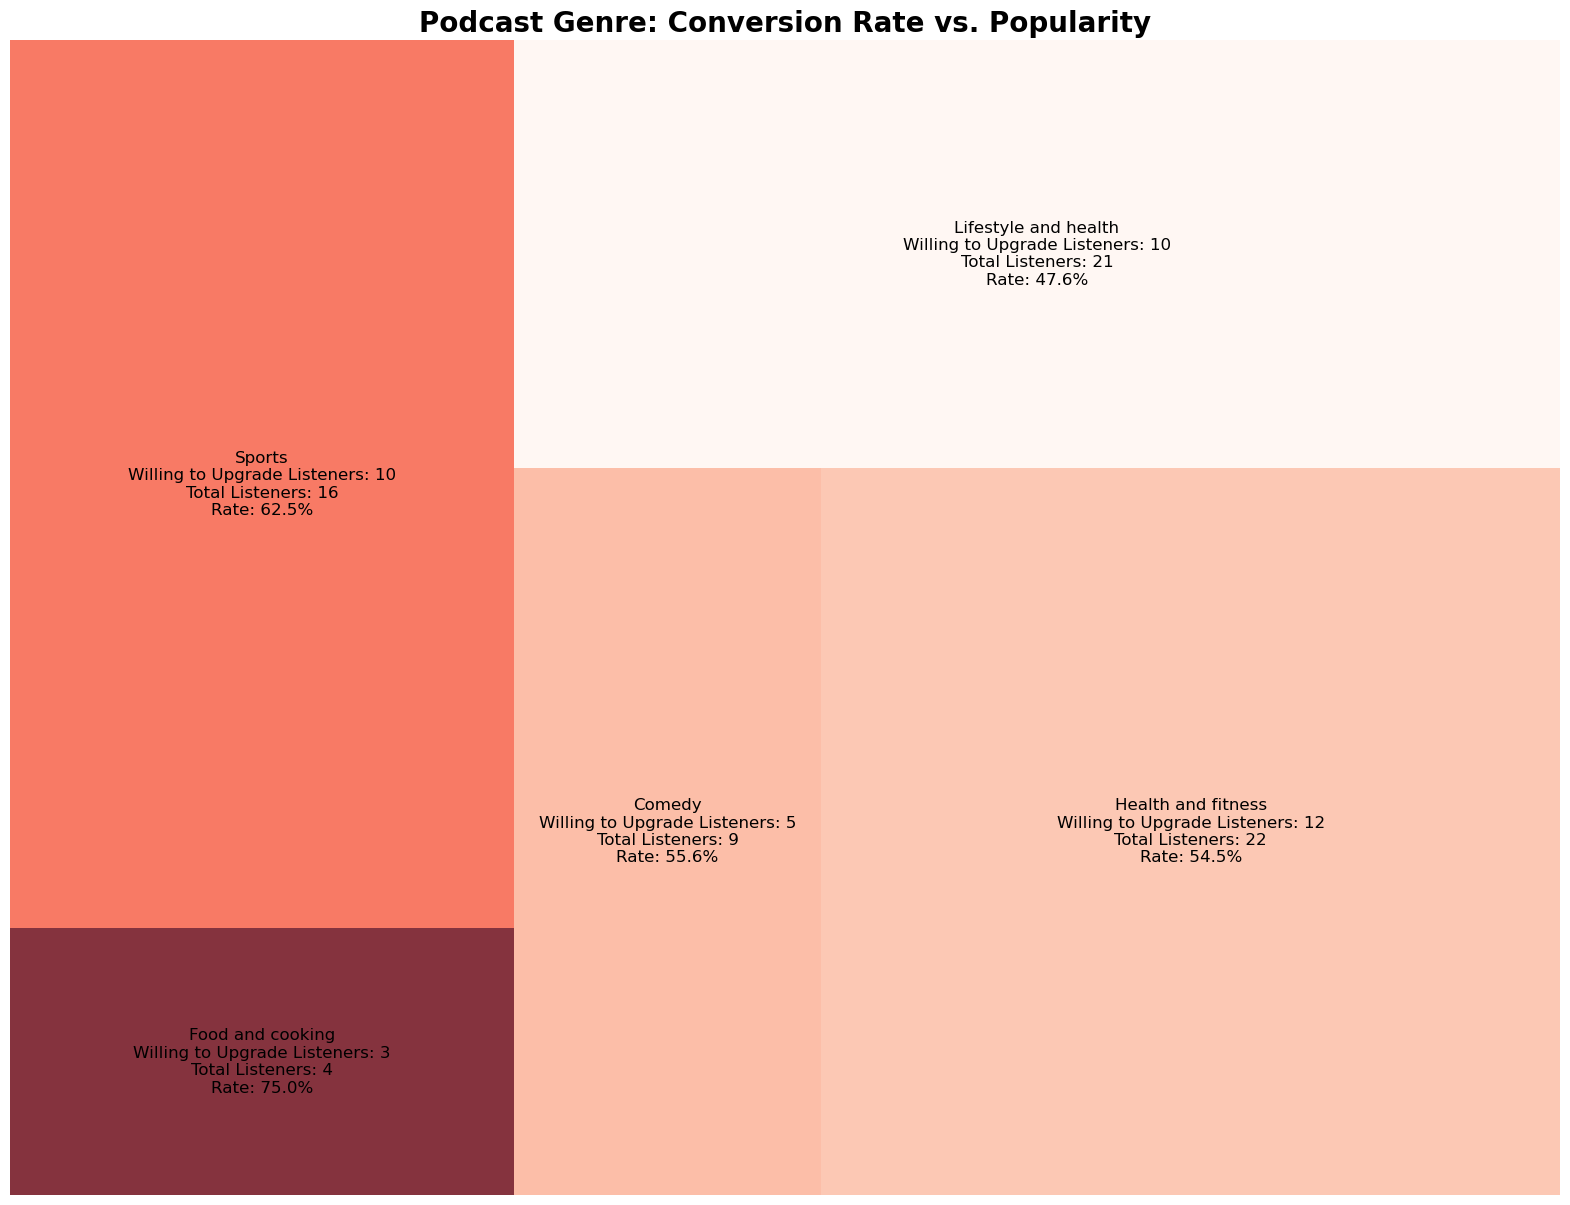

In [108]:
genre_stats2_plot = genre_stats2[genre_stats2['total_listeners'] >= min_total]

plt.figure(figsize=(20, 15))

# Create a colour mapping — the darker the colour, the higher the conversion rate
cmap = plt.cm.Reds
norm = plt.Normalize(vmin=genre_stats2_plot['conversion_rate'].min(), vmax=genre_stats2_plot['conversion_rate'].max())
colors = [cmap(norm(value)) for value in genre_stats2_plot['conversion_rate']]

# Create labels (Genre \n Willing Listeners \n Total Listeners \n Conversion Rate)
labels = [f"{row.genre_cleaned}\nWilling to Upgrade Listeners: {row.willing_listeners}\nTotal Listeners: {row.total_listeners}\nRate: {row.conversion_rate:.1%}"
          for index, row in genre_stats2_plot.iterrows()]

squarify.plot(sizes=genre_stats2_plot['willing_listeners'],
              label=labels,
              color=colors,
              alpha=0.8,
              text_kwargs={'fontsize': 12, 'color': 'black'})

plt.title('Podcast Genre: Conversion Rate vs. Popularity', fontsize=20, fontweight='bold')
plt.axis('off') 
plt.show()

1. **Music Listeners:**
Among free users who mainly listen to music, potential upgraders tend to prefer **melody, pop, rap, and classical genres**, and they usually listen in the **afternoon period**. This suggests that music consumption behaviour may be influenced by both **genre preference and time of day**, which could inform more targeted marketing or recommendation strategies.

2. **Popular Music Genre:**
Among all music genres, classical and rap listeners show the **highest conversion rates** (37.9% and 37.5%, respectively), although their audience bases are relatively small (29 and 16 users). In contrast, melody music attracts **the largest audience** (214 users), with **43 users willing to upgrade** to the Premium plan.

3. **Preferred Listen Frequency and Context:**
Most users prefer listening to music **while travelling, during leisure time, or when studying**, indicating that Spotify primarily serves as an **entertainment and relaxation tool** in users’ daily routines.
Therefore, the marketing team could position **Spotify as a lifestyle companion** — a platform that helps users unwind and enjoy their free time through personalised and enjoyable listening experiences.

4. **Popular Podcast Genre:**
Among podcast listeners, those engaging with **Health & Fitness, Sports, and Lifestyle & Wellness** content show the **highest willingness to upgrade** to the Premium plan.
This suggests that **health-conscious and active lifestyle audiences** represent a strong conversion segment, and targeted campaigns highlighting **exclusive health or wellness podcasts** could be particularly effective in driving premium subscriptions.

**Insight Summary:**

The contrast between music and podcast users — combined with variations in listening context and content type — reinforces the importance of **segmented marketing strategies**. By aligning promotions with **user motivation** (relaxation vs self-improvement) and **content preference**, Spotify can enhance both engagement and conversion efficiency.

## 3.3 Cramér’s V

Cramér’s V is used to measure the **strength of association between two categorical variables**. It is based on the Chi-square statistic and provides a value between **0 (no association)** and **1 (perfect association)**.

In this section, Cramér’s V is calculated between each categorical feature and the target variable `premium_sub_willingness` (whether a Free user is willing to upgrade).  

A higher Cramér’s V value indicates a stronger relationship between that feature and the user’s upgrade intention. This helps identify which demographic or behavioural factors are most related to conversion.

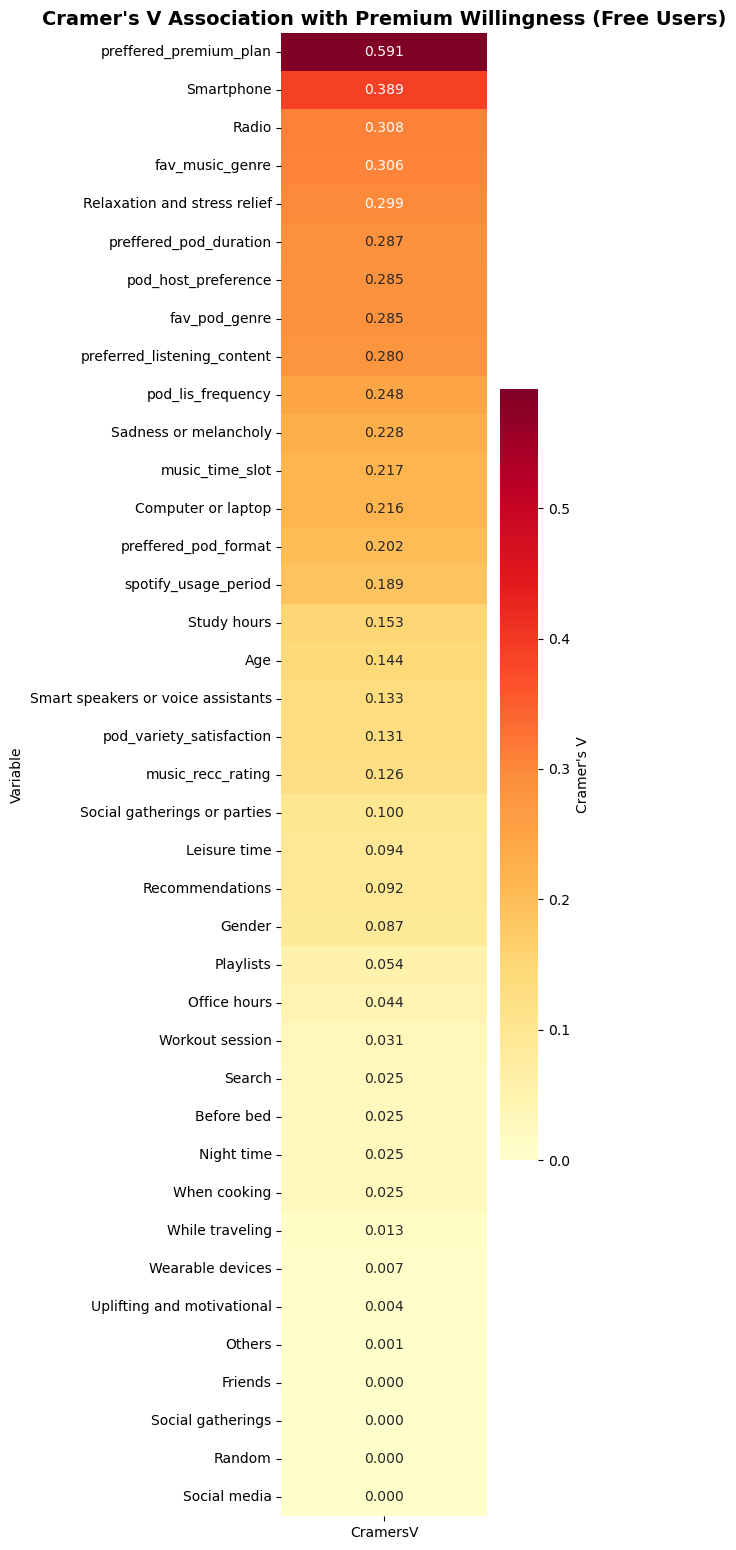

In [109]:
def cramers_v(x, y):
    # Calculate Cramér's V between two categorical variables.
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / (min(k - 1, r - 1)))

# --- Target variable ---
target = 'premium_sub_willingness'

# Exclude columns that are unsuitable for the Chi-Square test
# (e.g., multi-response fields that were already exploded)
columns_to_exclude = [
    target,
    'spotify_listening_device',   
    'music_Influencial_mood',
    'music_lis_frequency',
    'music_expl_method'      
]

# Select categorical features appropriate for testing
features_to_test = [col for col in df_free.columns if col not in columns_to_exclude]

# --- Compute Cramér's V for each categorical column against the target variable ---
assoc = {}
for col in features_to_test:
    try:
        assoc[col] = cramers_v(df_free[col], df_free[target])
    except Exception:
        assoc[col] = np.nan

# Convert the result dictionary into a DataFrame and sort by strength of association
assoc_df = (
    pd.DataFrame.from_dict(assoc, orient='index', columns=['CramersV'])
    .sort_values('CramersV', ascending=False)
)

assoc_df.head(15)

# --- Visualise associations using a heatmap ---
plt.figure(figsize=(6, len(assoc_df) * 0.4))
sns.heatmap(
    assoc_df,
    annot=True,
    cmap='YlOrRd',
    cbar_kws={'label': "Cramer's V"},
    fmt='.3f'
)
plt.title("Cramer's V Association with Premium Willingness (Free Users)", fontsize=14, fontweight='bold')
plt.xlabel('')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


**Variable Importance Based on Cramér’s V Analysis**

Based on the Cramér’s V plot, the top five variables most associated with free users’ willingness to upgrade are:
1. `Preferred Premium Plan` (0.59) – very strong association
2. `Smartphone` (0.389) – moderate to strong association
3. `Radio` (0.308) – moderate to strong association
4. `Favourite Music Genre` (0.306) – moderate to strong association
5. `Relaxation and Stress Relief` (0.299) – weak to moderate association

Most of these variables are related to **listening devices** and **music moods**, suggesting that users’ **preferred genres and device types** play an important role in conversion behaviour. This implies that identifying **popular genres and device usage patterns** can significantly improve the **efficiency of Premium plan promotion** through more personalised and targeted marketing.

Regarding **podcast listeners**, the top three variables associated with upgrade willingness are:

1. `Preferred Podcast Duration` (0.287) – weak to moderate association
2. `Podcast Host Preference` (0.285) – weak to moderate association
3. `Favourite Podcast Genre` (0.285) – weak to moderate association

Although the associations are weaker than those in the music category, these variables still highlight that **podcast content characteristics**—such as duration, host style, and topic—play a role in shaping user loyalty and upgrade intention. Therefore, **analysing users’ podcast listening records** remains essential for building detailed target audience profiles and designing **content-specific engagement strategies**.

## 3.4 Chi-Square Test

The Chi-Square (χ²) test is used to determine whether there is a **statistically significant relationship** between two categorical variables — in this case, each user attribute and the target variable `premium_sub_willingness` (willingness to upgrade to Premium).

This test complements Cramér’s V by providing the **significance level (p-value)** of each association. A smaller p-value indicates stronger evidence that the variable and upgrade intention are related (i.e., the difference in distributions is unlikely to be due to chance).

A significance threshold of α = 0.01 is used to identify features with statistically meaningful relationships.

In [110]:
target_variable = 'premium_sub_willingness'

# Exclude columns that are unsuitable for the Chi-Square test
# (e.g., multi-response fields that were already exploded)
columns_to_exclude = [
    target_variable,
    'spotify_listening_device',   
    'music_Influencial_mood',
    'music_lis_frequency',
    'music_expl_method'      
]

# Select categorical features appropriate for testing
features_to_test = [col for col in df_free.columns if col not in columns_to_exclude]

# --- Run the Chi-Square test for each feature and store results ---
results = []

for feature in features_to_test:
    # Create a contingency table between the feature and the target variable
    contingency_table = pd.crosstab(df_free[feature], df_free[target_variable])
    
    # Perform the Chi-Square test of independence
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Store feature name and corresponding p-value
    results.append({
        'Feature': feature,
        'p-value': round(p_value, 4)
    })

# --- Organise and display results ---
results_df = pd.DataFrame(results)

# Define the significance threshold (alpha)
alpha = 0.01
results_df['Significance'] = np.where(
    results_df['p-value'] < alpha,
    'Significant (✓)',
    'Not Significant (x)'
)

# Sort by p-value — smaller p-values indicate stronger associations
results_df = results_df.sort_values(by='p-value', ascending=True)

# Display final results
print("\nChi-Square Test Results for all features vs. Premium Willingness:")
print(results_df.to_string(index=False))


Chi-Square Test Results for all features vs. Premium Willingness:
                           Feature  p-value        Significance
             Sadness or melancholy   0.0000     Significant (✓)
                        Smartphone   0.0000     Significant (✓)
            preffered_premium_plan   0.0000     Significant (✓)
       preferred_listening_content   0.0000     Significant (✓)
                   fav_music_genre   0.0000     Significant (✓)
                   music_time_slot   0.0000     Significant (✓)
                             Radio   0.0000     Significant (✓)
                 pod_lis_frequency   0.0000     Significant (✓)
      Relaxation and stress relief   0.0000     Significant (✓)
               pod_host_preference   0.0000     Significant (✓)
            preffered_pod_duration   0.0000     Significant (✓)
                Computer or laptop   0.0000     Significant (✓)
              spotify_usage_period   0.0016     Significant (✓)
                       Study hours   

**Significant Variables - Users Preference:**

`spotify_usage_period`, `preffered_premium_plan`, `preferred_listening_content`

**Significant Variables - Listening Devices:**

`Smartphone`, `Radio`, `Computer or laptop`, `Smart speakers or voice assistants`

**Significant Variables - Music:**

`Sadness or melancholy`, `fav_music_genre`, `music_time_slot`, `Relaxation and stress relief`, `Study hours`

**Significant Variables - Podcast:**

`pod_lis_frequency`, `pod_host_preference`, `preffered_pod_duration`, `preffered_pod_format`, `fav_pod_genre`

## 3.5 Customer Segmentation (K-Means)

Use K-Means clustering to segment Free users into behaviourally distinct groups based on features that are statistically associated with upgrade willingness.

### 3.5.1 K-Means Modelling

**Method (overview)**

1. **Feature selection.** Use features flagged as significant by the Chi-Square tests.
2. **Encoding.** One-hot encode categorical variables (drop first to avoid full multicollinearity).
3. **Model selection.** Use the Elbow method (inertia) to choose a reasonable number of clusters.
4. **Fit & label.** Train K-Means and assign a cluster to each user.
5. **Profiling.** Summarise cluster size, conversion rate, and device usage composition.

In [111]:
# Select features that were significant in the Chi-Square tests
significant_features = list(
    results_df[results_df['Significance'] == 'Significant (✓)']['Feature']
)

# 1) One-Hot Encode the selected features (drop_first to reduce redundancy)
df_for_clustering = pd.get_dummies(
    df_free[significant_features],
    drop_first=True
)

c:\Users\jeffs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\jeffs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\jeffs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\jeffs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

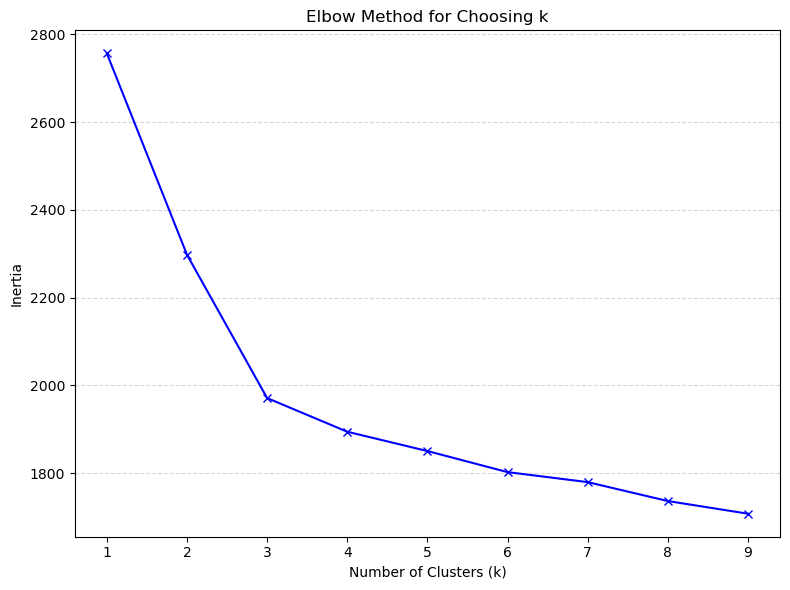

In [112]:
# 2) Elbow method to pick a reasonable k
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_for_clustering)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Choosing k')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 3.5.2 Build Cluster Profile

In [113]:
# 3) Fit the clustering model (set k based on the elbow)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_for_clustering)

# Attach cluster labels back to the Free-user DataFrame
df_free = df_free.copy()
df_free['Cluster'] = clusters

# 4) Quick cluster mode profile (most frequent category per column)
#    For numeric columns, this will still return the mode.
cluster_profile = df_free.groupby('Cluster').agg(lambda x: x.value_counts().index[0])
cluster_profile

c:\Users\jeffs\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,Age,Gender,spotify_usage_period,spotify_listening_device,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,...,When cooking,While traveling,Workout session,Friends,Others,Playlists,Radio,Recommendations,Search,Social media
Cluster,,,,,,,,,,,,,,,,,,,,,
0,20-35,Female,More than 2 years,Smartphone,0,No Response,Music,Melody,Night,Relaxation and stress relief,...,0,1,0,0,0,0,0,1,0,0
1,20-35,Female,6 months to 1 year,Computer or laptop,1,Duo Plan - GBP 16.99/month,Podcast,classical,Afternoon,Sadness or melancholy,...,0,1,0,0,0,0,1,0,0,0
2,20-35,Female,More than 2 years,Smartphone,0,No Response,Music,Melody,Night,Relaxation and stress relief,...,0,1,0,0,0,1,0,1,0,0


### 3.5.3 Profiling clusters' upgrade willingness and users behaviour (listening devices and preferred premium plans)

User count per cluster:
Cluster
0    124
1     82
2    218
Name: count, dtype: int64

Estimated potential coverts per cluster:
Cluster
0    22
1    51
2    41
dtype: int32


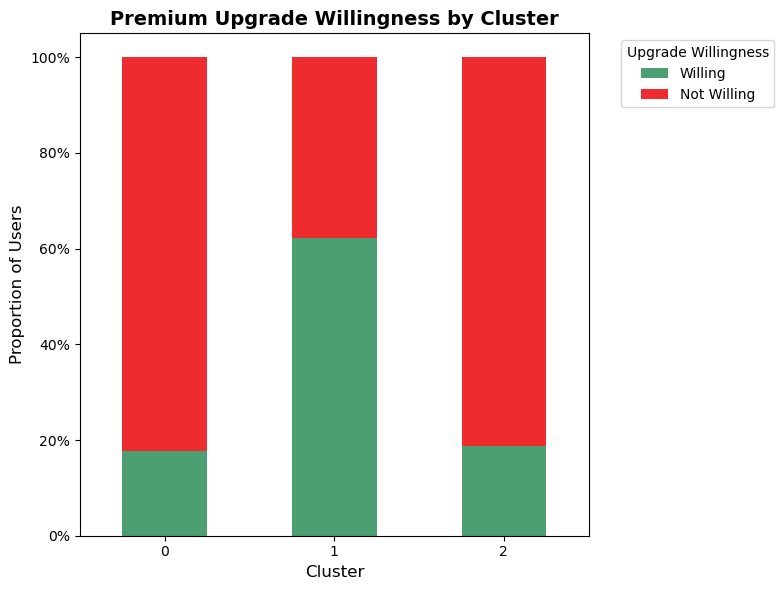

In [114]:
# Cluster sizes
cluster_sizes = df_free['Cluster'].value_counts().sort_index()
print("User count per cluster:")
print(cluster_sizes)

# Conversion rates per cluster (guard against missing class '1')
conv_table = df_free.groupby('Cluster')['premium_sub_willingness'].value_counts(normalize=True).unstack()
conversion_rates = conv_table.get(1, pd.Series(0, index=conv_table.index)).fillna(0)

# Estimated potential converts per cluster
potential_converts = (cluster_sizes * conversion_rates).round(0).astype(int)
print("\nEstimated potential coverts per cluster:")
print(potential_converts)

# Reconstruct proportions for both classes
conversion_data = pd.DataFrame({
    'Willing': conversion_rates,
    'Not Willing': 1 - conversion_rates
})

# --- Plot ---
conversion_data.plot(kind='bar', stacked=True, 
                     color=['#4C9F70', "#EB0509D8"],   # green for willing, red for not
                     figsize=(8, 6)
)

# --- Formatting ---
plt.title('Premium Upgrade Willingness by Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Proportion of Users', fontsize=12)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=0)
plt.legend(title='Upgrade Willingness', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Device usage proportion by cluster (%):
         Smartphone  Computer or laptop  Wearable devices  Smart speakers or voice assistants
Cluster                                                                                      
0            95.97%              17.74%             6.45%                               8.06%
1            13.41%              57.32%             9.76%                              43.90%
2            97.71%              13.30%             7.80%                               4.59%


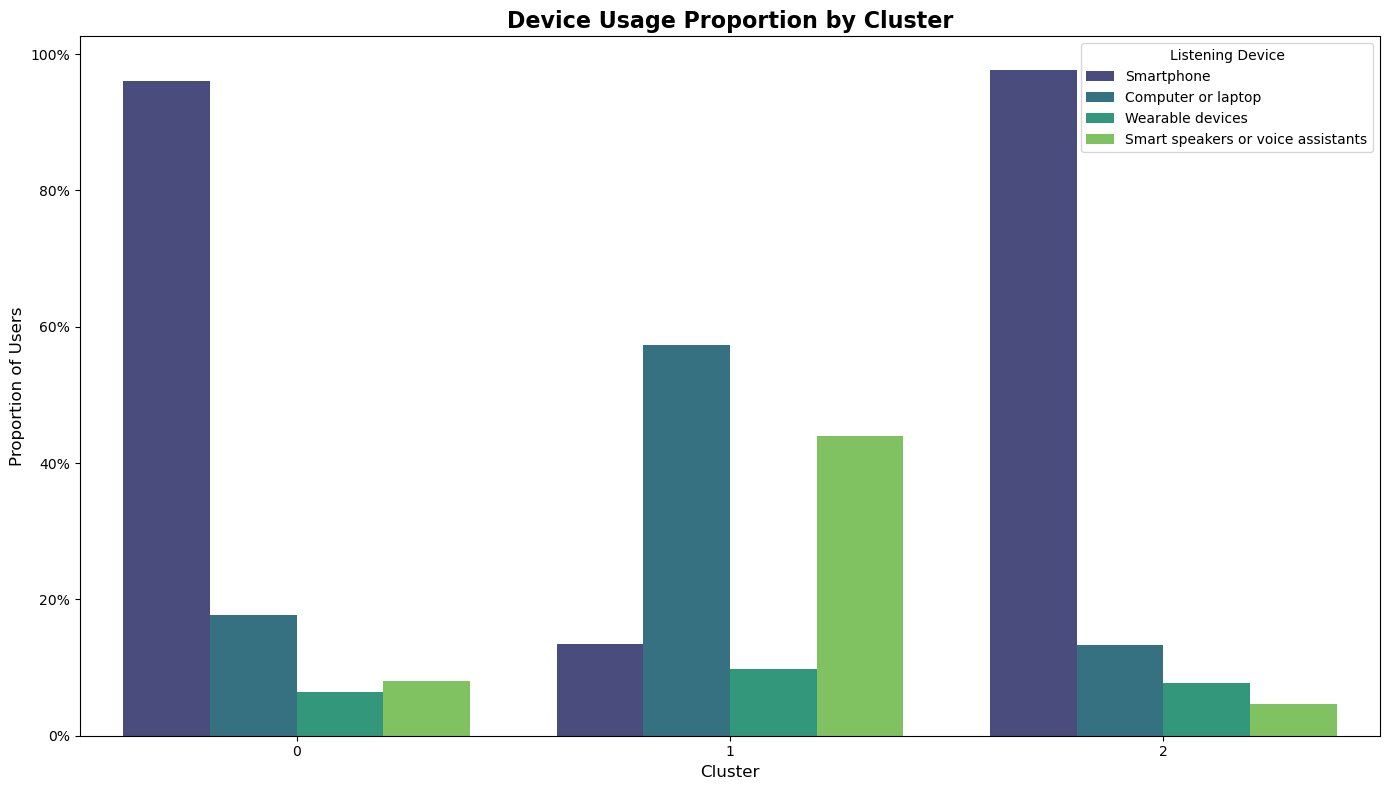

In [115]:
# ---- Device composition by cluster (multi-select field pre-encoded as dummies) ----
# Ensure these columns exist in df_free (created earlier from multi-select device data)
devices = ['Smartphone', 'Computer or laptop', 'Wearable devices', 'Smart speakers or voice assistants']

# Average of binary dummies = proportion of users using that device in the cluster
device_profile = df_free.groupby('Cluster')[devices].mean()

print("\nDevice usage proportion by cluster (%):")
print((device_profile * 100).round(2).to_string(float_format='%.2f%%'))


# Visualise device composition across clusters (stacked bar or grouped bar)
df_melted1 = device_profile.reset_index().melt(
    id_vars='Cluster',
    var_name='Device',
    value_name='Proportion of Users'
)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_melted1,
    x='Cluster',
    y='Proportion of Users',
    hue='Device',
    palette='viridis'
)

# Styling
plt.title('Device Usage Proportion by Cluster', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Proportion of Users', fontsize=12)
plt.legend(title='Listening Device', fontsize=10)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
plt.tight_layout()
plt.show()

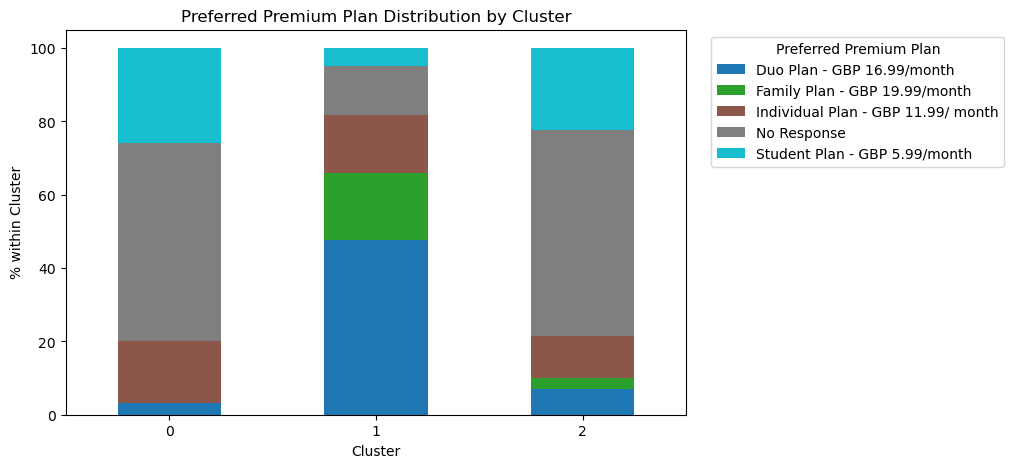

In [116]:
ct1 = pd.crosstab(df_free['Cluster'], df_free['preffered_premium_plan'], normalize='index') * 100
ct1.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab10')
plt.title('Preferred Premium Plan Distribution by Cluster')
plt.ylabel('% within Cluster')
plt.xticks(rotation=0)
plt.legend(title='Preferred Premium Plan', bbox_to_anchor=(1.03, 1))
plt.show()


Music mood proportion by cluster (%):
         Sadness or melancholy  Social gatherings or parties  Relaxation and stress relief  Uplifting and motivational
Cluster                                                                                                               
0                       29.03%                        19.35%                        85.48%                      33.87%
1                       46.34%                         9.76%                        19.51%                      45.12%
2                       22.48%                        18.81%                        88.99%                      33.94%


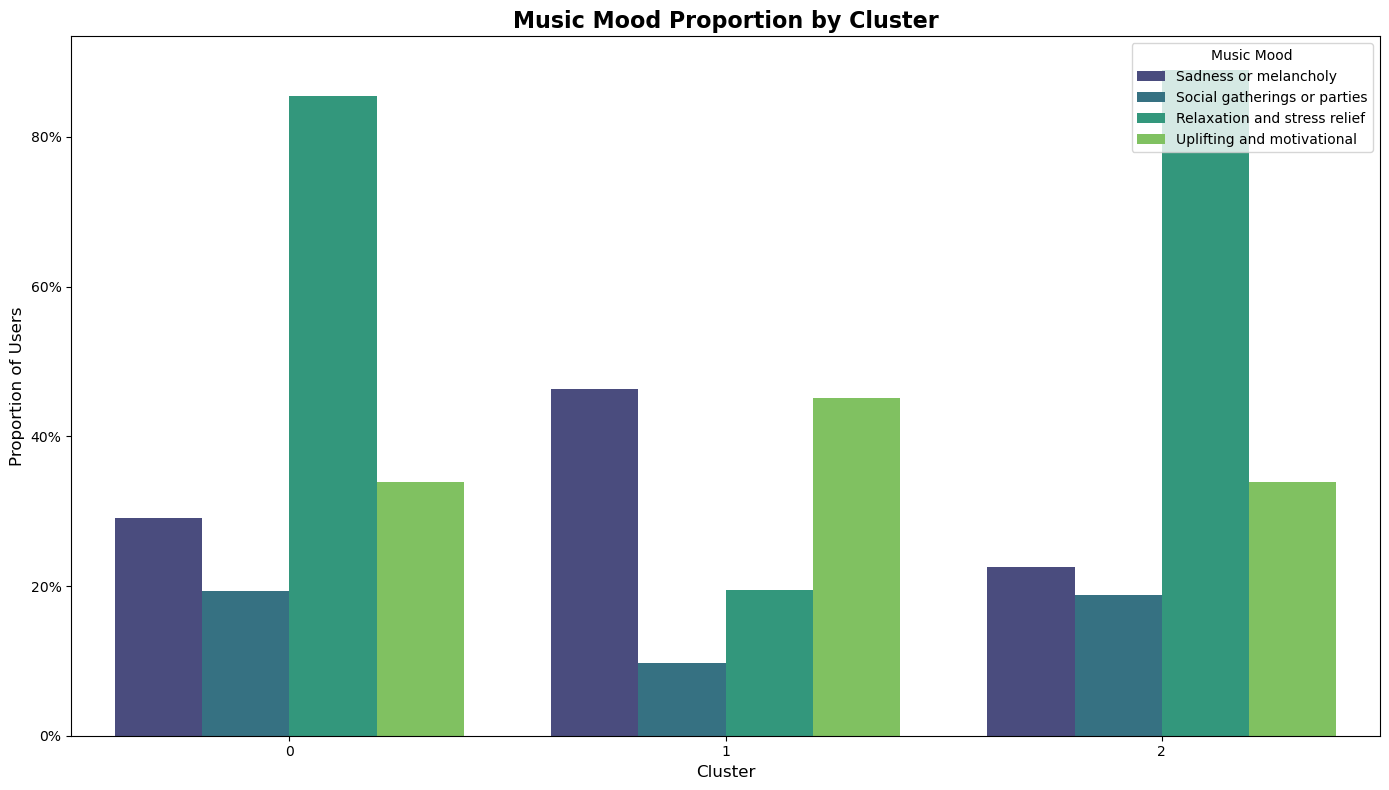

In [117]:
# ---- Device composition by cluster (multi-select field pre-encoded as dummies) ----
# Ensure these columns exist in df_free (created earlier from multi-select device data)
mood = ['Sadness or melancholy', 'Social gatherings or parties', 'Relaxation and stress relief', 'Uplifting and motivational']

# Average of binary dummies = proportion of users using that device in the cluster
mood_profile = df_free.groupby('Cluster')[mood].mean()

print("\nMusic mood proportion by cluster (%):")
print((mood_profile * 100).round(2).to_string(float_format='%.2f%%'))


# Visualise device composition across clusters (stacked bar or grouped bar)
df_melted2 = mood_profile.reset_index().melt(
    id_vars='Cluster',
    var_name='Mood',
    value_name='Proportion of Users'
)

plt.figure(figsize=(14, 8))
sns.barplot(
    data=df_melted2,
    x='Cluster',
    y='Proportion of Users',
    hue='Mood',
    palette='viridis'
)

# Styling
plt.title('Music Mood Proportion by Cluster', fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Proportion of Users', fontsize=12)
plt.legend(title='Music Mood', fontsize=10, loc='upper right')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
plt.tight_layout()
plt.show()

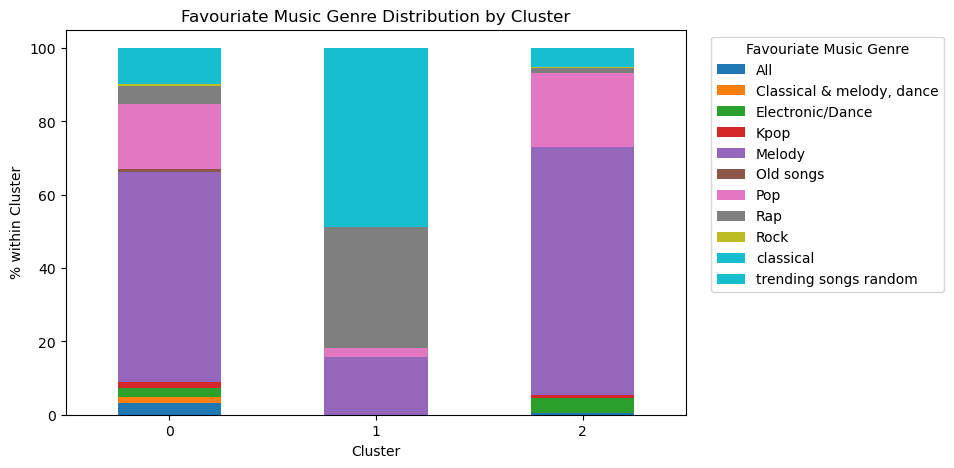

In [118]:
ct2 = pd.crosstab(df_free['Cluster'], df_free['fav_music_genre'], normalize='index') * 100
ct2.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab10')

plt.title('Favouriate Music Genre Distribution by Cluster')
plt.ylabel('% within Cluster')
plt.xticks(rotation=0)
plt.legend(title='Favouriate Music Genre', bbox_to_anchor=(1.03, 1))
plt.show()

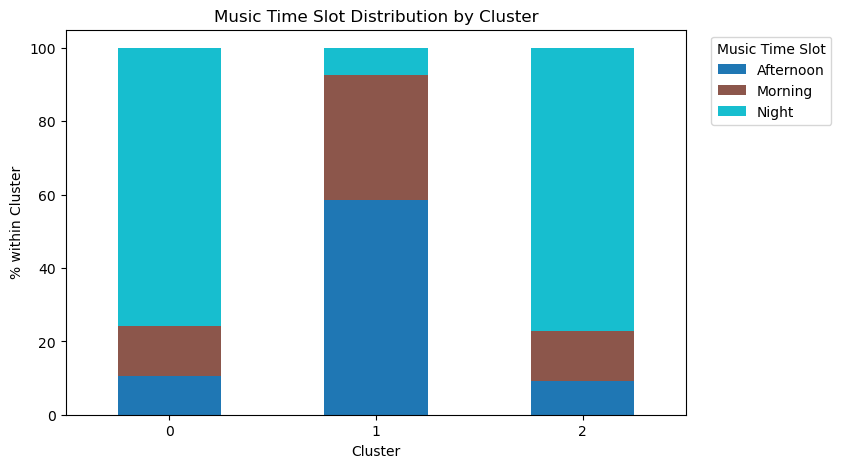

In [119]:
ct3 = pd.crosstab(df_free['Cluster'], df_free['music_time_slot'], normalize='index') * 100
ct3.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab10')

plt.title('Music Time Slot Distribution by Cluster')
plt.ylabel('% within Cluster')
plt.xticks(rotation=0)
plt.legend(title='Music Time Slot', bbox_to_anchor=(1.03, 1))
plt.show()

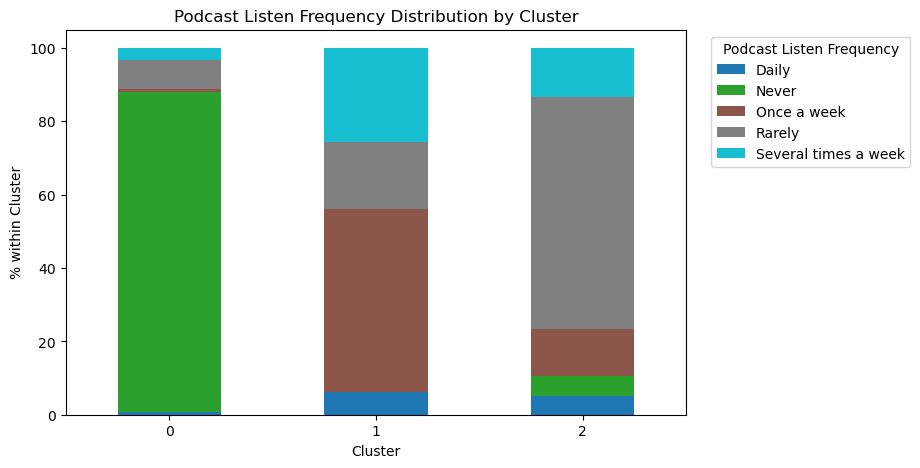

In [120]:
ct4 = pd.crosstab(df_free['Cluster'], df_free['pod_lis_frequency'], normalize='index') * 100
ct4.plot(kind='bar', stacked=True, figsize=(8,5), colormap='tab10')

plt.title('Podcast Listen Frequency Distribution by Cluster')
plt.ylabel('% within Cluster')
plt.xticks(rotation=0)
plt.legend(title='Podcast Listen Frequency', bbox_to_anchor=(1.03, 1))
plt.show()

**Findings and Insights:**

The K-Means segmentation of free Spotify users (k=3) identified three distinct user clusters with clear behavioural and attitudinal differences towards premium plan adoption. 

**Cluster 1**, representing the smallest group (n=82), stands out as the most conversion-ready segment, with over **60% expressing willingness to upgrade** and an estimated 51 potential converts. These users demonstrate **multi-device listening habits**, especially via computers (57%) and smart speakers (44%), indicating higher engagement and audio quality awareness. 

They are also emotionally diverse listeners, frequently engaging with both **sadness and uplifting** music moods, listening during **daytime or morning hours**, and consuming podcasts several times a week. Their **preference for Duo and Family premium plans** suggests shared usage and higher disposable income, making them the most viable targets for premium promotion.

In contrast, **Cluster 0** (n=124) and **Cluster 2** (n=218) are dominated by **mobile-only listeners** (around 96–98%), who primarily use Spotify **at night** for **relaxation and stress relief**. 

Both groups display **limited podcast engagement** and stronger preference for popular or melodic genres, reflecting casual or mood-based listening patterns. Their low upgrade willingness (below 20%) and high non-response rates in plan preferences indicate a lower financial readiness or satisfaction with the free version. 

Overall, this segmentation highlights **Cluster 1 as the key opportunity for conversion** through personalised marketing campaigns that emphasise multi-device access, ad-free listening, and shared value in premium plans, while Clusters 0 and 2 could be nurtured gradually through affordable student or introductory offers and emotionally resonant messaging focused on relaxation and enjoyment.


# Section 4. Premium User Churn Analysis

This section analyses churn risk among **Premium (paid) users**. We first define churn, compute baseline churn, inspect univariate churn rates across key features, run a **Chi-Square screening** to identify statistically significant churn drivers, and then build a **Logistic Regression** model with interpretability (coefficients) and a readable confusion matrix.

## 4.1 Define Churn & Baseline

- Define `is_churn = 1` if a Premium user reports “No” to `premium_sub_willingness`; otherwise 0.
- Report overall churn rate and class balance.

In [121]:
# 1) Select Premium users
df_premium = df_stats[df_stats['spotify_subscription_plan'] == 'Premium (paid subscription)'].copy()

# 2) Define churn label: if 'premium_sub_willingness' == 'No' → churn (1); else 0
df_premium['is_churn'] = (df_premium['premium_sub_willingness'] == 'No').astype(int)

# 3) Baseline churn rate
overall_churn_rate = df_premium['is_churn'].mean()
print(f"Overall churn rate among Premium users: {overall_churn_rate:.2%}")

# Class balance
print("\nChurned vs. Retained (counts):")
print(df_premium['is_churn'].value_counts())

Overall churn rate among Premium users: 25.00%

Churned vs. Retained (counts):
is_churn
0    72
1    24
Name: count, dtype: int64


## 4.2 Univariate Churn Rate by Feature

Compare churn rates by selected categorical features (e.g., `preferred_listening_content`, `spotify_usage_period`, `fav_music_genre`) with bar charts (percentage on y-axis).


Churn Rate by Preferred Premium Plan:
preffered_premium_plan
Student Plan - GBP 5.99/month          0.00%
Individual Plan - GBP 11.99/ month     5.56%
Duo Plan - GBP 16.99/month            30.77%
Family Plan - GBP 19.99/month         41.18%
Name: is_churn, dtype: object


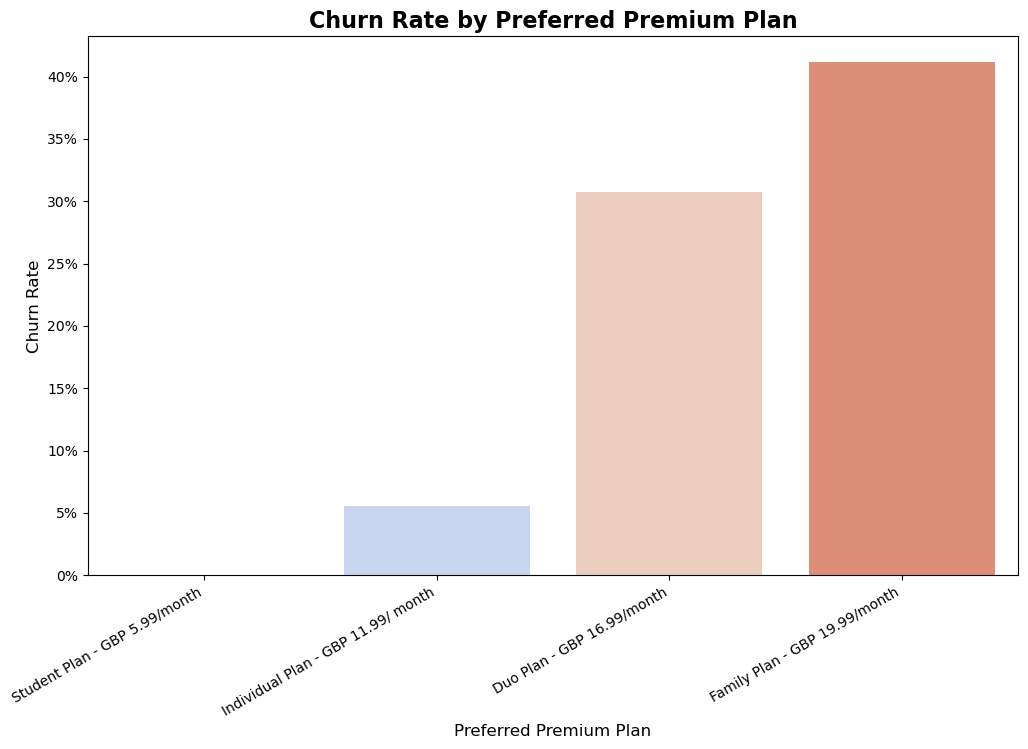

In [122]:
feature_to_analyze = 'preffered_premium_plan'

plan_order1 = ['Student Plan - GBP 5.99/month',
 'Individual Plan - GBP 11.99/ month',
 'Duo Plan - GBP 16.99/month',
 'Family Plan - GBP 19.99/month']

churn_rate_by_feature = df_premium.groupby(feature_to_analyze)['is_churn'].mean()
churn_rate_by_feature = churn_rate_by_feature.reindex(plan_order1)

print(f"\nChurn Rate by Preferred Premium Plan:")
print(churn_rate_by_feature.map('{:.2%}'.format)) 

plt.figure(figsize=(12, 7))
sns.barplot(x=churn_rate_by_feature.index, y=churn_rate_by_feature.values, palette='coolwarm')

plt.title(f'Churn Rate by Preferred Premium Plan', fontsize=16, fontweight='bold')
plt.ylabel('Churn Rate', fontsize=12)
plt.xlabel('Preferred Premium Plan', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()


Churn Rate by Spotify Usage Period:
spotify_usage_period
Less than 6 months    42.86%
6 months to 1 year    37.04%
1 year to 2 years     25.81%
More than 2 years      9.68%
Name: is_churn, dtype: object


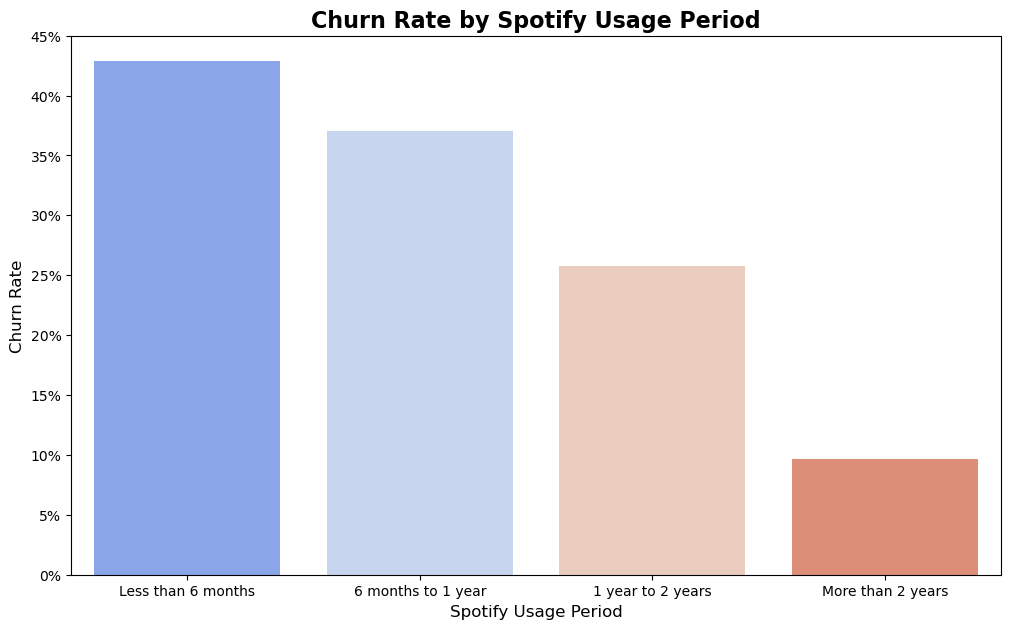

In [123]:
feature_to_analyze = 'spotify_usage_period'

churn_rate_by_feature = df_premium.groupby(feature_to_analyze)['is_churn'].mean().sort_values(ascending=False)

print(f"\nChurn Rate by Spotify Usage Period:")
print(churn_rate_by_feature.map('{:.2%}'.format)) 

plt.figure(figsize=(12, 7))
sns.barplot(x=churn_rate_by_feature.index, y=churn_rate_by_feature.values, palette='coolwarm')

plt.title(f'Churn Rate by Spotify Usage Period', fontsize=16, fontweight='bold')
plt.ylabel('Churn Rate', fontsize=12)
plt.xlabel('Spotify Usage Period', fontsize=12)
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()


Churn Rate by Music and Podcast:
preferred_listening_content
Music      25.42%
Podcast    24.32%
Name: is_churn, dtype: object


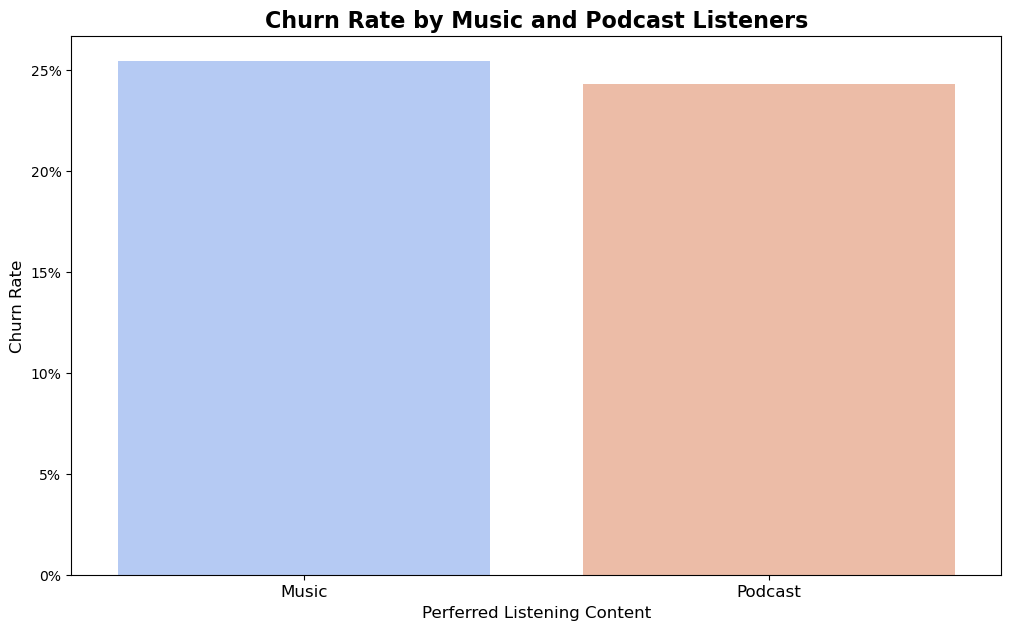

In [124]:
feature_to_analyze = 'preferred_listening_content'
churn_rate_by_feature = df_premium.groupby(feature_to_analyze)['is_churn'].mean().sort_values(ascending=False)

print(f"\nChurn Rate by Music and Podcast:")
print(churn_rate_by_feature.map('{:.2%}'.format)) 

plt.figure(figsize=(12, 7))
sns.barplot(x=churn_rate_by_feature.index, y=churn_rate_by_feature.values, palette='coolwarm')

plt.title(f'Churn Rate by Music and Podcast Listeners', fontsize=16, fontweight='bold')
plt.ylabel('Churn Rate', fontsize=12)
plt.xlabel('Perferred Listening Content', fontsize=12)
plt.xticks(rotation=0, fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()


Churn Rate by Favouriate Music Genre:
fav_music_genre
All                 100.00%
classical            48.00%
Melody               21.43%
Rap                  15.79%
Pop                  11.76%
Electronic/Dance      0.00%
Rock                  0.00%
Name: is_churn, dtype: object


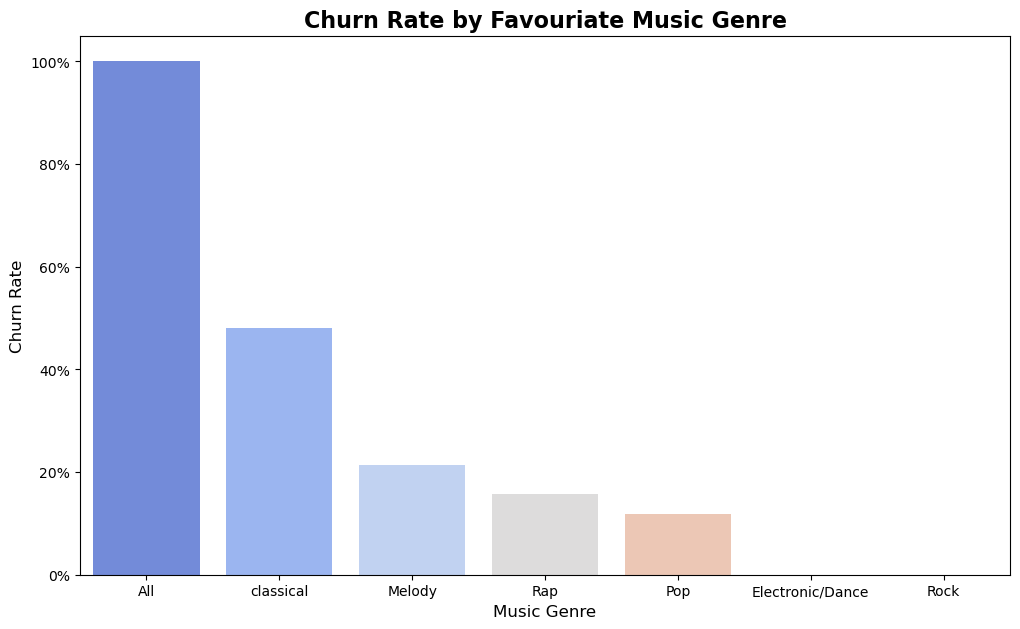

In [125]:
churn_rate_by_feature = df_premium.groupby('fav_music_genre')['is_churn'].mean().sort_values(ascending=False)

print(f"\nChurn Rate by Favouriate Music Genre:")
print(churn_rate_by_feature.map('{:.2%}'.format)) 

plt.figure(figsize=(12, 7))
sns.barplot(x=churn_rate_by_feature.index, y=churn_rate_by_feature.values, palette='coolwarm')

plt.title(f'Churn Rate by Favouriate Music Genre', fontsize=16, fontweight='bold')
plt.ylabel('Churn Rate', fontsize=12)
plt.xlabel('Music Genre', fontsize=12)
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()


Churn Rate by Podcast Format:
preffered_pod_format
Interview         42.11%
No Response       27.27%
Story telling     23.08%
Conversational    17.65%
Educational       10.00%
Name: is_churn, dtype: object


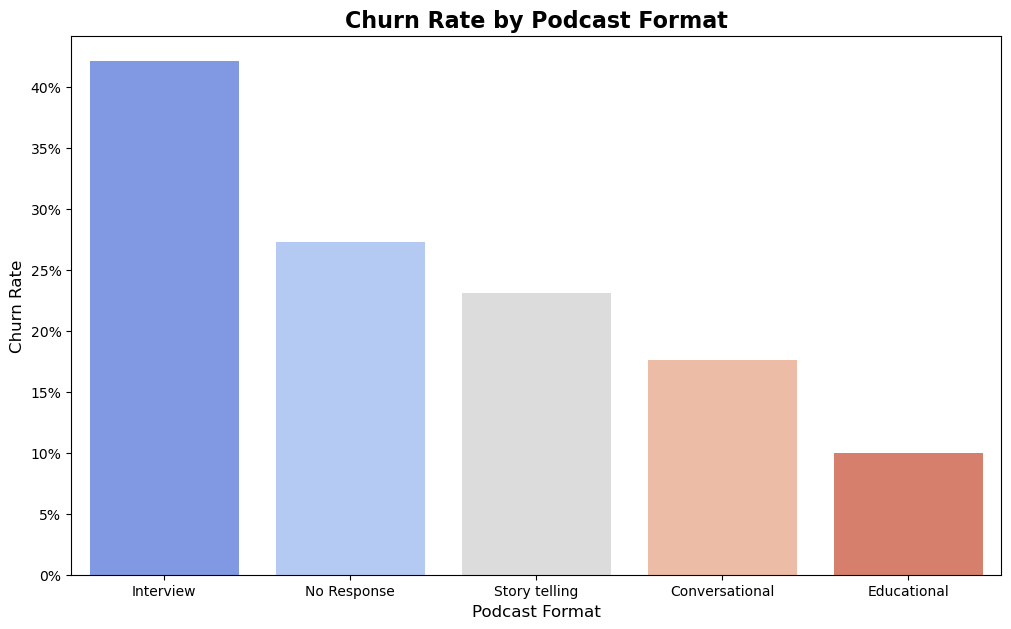

In [126]:
feature_to_analyze = 'preffered_pod_format'

churn_rate_by_feature = df_premium.groupby(feature_to_analyze)['is_churn'].mean().sort_values(ascending=False)

print(f"\nChurn Rate by Podcast Format:")
print(churn_rate_by_feature.map('{:.2%}'.format)) 

plt.figure(figsize=(12, 7))
sns.barplot(x=churn_rate_by_feature.index, y=churn_rate_by_feature.values, palette='coolwarm')

plt.title(f'Churn Rate by Podcast Format', fontsize=16, fontweight='bold')
plt.ylabel('Churn Rate', fontsize=12)
plt.xlabel('Podcast Format', fontsize=12)
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
plt.show()

Key Findings:

The churn analysis among premium Spotify users reveals that customer retention varies significantly across usage behaviours and plan types. 

Users subscribed to **higher-priced plans** such as the Family (£19.99/month) and Duo (£16.99/month) show the highest churn rates (over 30–40%), suggesting potential dissatisfaction or shared-account fatigue. In contrast, Individual and Student plan users exhibit notably lower churn, indicating stronger perceived value among solo or cost-sensitive subscribers. 

Churn also **decreases markedly with platform tenure**, falling from over 40% for users with less than six months’ experience to below 10% for those using Spotify for more than two years, confirming that loyalty strengthens with time. 

Music and podcast listeners have similar churn levels (~25%), while content preference within these categories matters: **listeners favouring “All genres” or “classical” music churn more**, whereas pop and electronic fans are more stable. For podcasts, “Interview” formats show the highest churn, while “Educational” content retains users better. 

Overall, these findings suggest that enhancing long-term engagement and tailoring content quality for high-price plan users are critical levers for improving retention.

## 4.3 Chi-Square Screening for Churn Drivers

- For each candidate feature, run **Chi-Square test** vs. `is_churn`.
- Rank features by p-value and flag significance at α = 0.01.

In [127]:
# Exclude labels and multi-select raw fields (use their encoded versions instead)
columns_to_exclude = ['spotify_subscription_plan', 'premium_sub_willingness', 'is_churn']
features_to_test = [col for col in df_premium.columns if col not in columns_to_exclude]

churn_results = []
for feature in features_to_test:
    contingency_table = pd.crosstab(df_premium[feature], df_premium['is_churn'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    churn_results.append({'Feature': feature, 'p-value': p_value})

churn_drivers_df = pd.DataFrame(churn_results).sort_values(by='p-value', ascending=True).reset_index(drop=True)
churn_drivers_df['Significance'] = np.where(churn_drivers_df['p-value'] < 0.01, 'Significant (v)', 'Not Significant (x)')


print("\nFeatures significantly associated with churn (sorted by p-value):")
print(churn_drivers_df)


Features significantly associated with churn (sorted by p-value):
                               Feature   p-value         Significance
0               preffered_premium_plan  0.000005      Significant (v)
1             spotify_listening_device  0.000437      Significant (v)
2                  pod_host_preference  0.000825      Significant (v)
3         Relaxation and stress relief  0.009522      Significant (v)
4                           Smartphone  0.009522      Significant (v)
5                         Leisure time  0.010142  Not Significant (x)
6                      Recommendations  0.011750  Not Significant (x)
7                    music_recc_rating  0.011766  Not Significant (x)
8                   Computer or laptop  0.018321  Not Significant (x)
9                      fav_music_genre  0.022795  Not Significant (x)
10                       fav_pod_genre  0.023536  Not Significant (x)
11                     music_time_slot  0.034493  Not Significant (x)
12            pod_varie

**Signifcant Variables:** `preffered_premium_plan`, `spotify_listening_device`, `pod_host_preference`, `Relaxation and stress relief`, `Smartphone` 

## 4.4 Logistic Regression (Classification)

- One-hot encode features, split train/test with stratification, scale features, and fit **Logistic Regression** (`class_weight='balanced'`).
- Report accuracy and classification report.
- Show an annotated confusion matrix.

In [128]:
# Choose predictors: drop labels and raw multi-select text columns
features_to_use = [col for col in df_premium.columns if col not in [
    'spotify_subscription_plan', 
    'premium_sub_willingness', 
    'is_churn',
    'spotify_listening_device', 
    'music_Influencial_mood',    
    'music_expl_method',
    'music_lis_frequency'
]]

# One-Hot Encode predictors only
df_model_ready = pd.get_dummies(df_premium, columns=features_to_use, drop_first=True)

y = df_model_ready['is_churn']
X = df_model_ready.drop(['is_churn', 'spotify_subscription_plan', 'premium_sub_willingness', 'spotify_listening_device', 'music_Influencial_mood', 'music_expl_method', 'music_lis_frequency'], axis=1)

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features (important for LR stability/interpretation)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression (handle class imbalance)

lr_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred_lr = lr_model.predict(X_test_scaled)

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Not Churn (0)', 'Churn (1)']))

Logistic Regression Accuracy: 70.00%

Classification Report:
               precision    recall  f1-score   support

Not Churn (0)       0.80      0.80      0.80        15
    Churn (1)       0.40      0.40      0.40         5

     accuracy                           0.70        20
    macro avg       0.60      0.60      0.60        20
 weighted avg       0.70      0.70      0.70        20



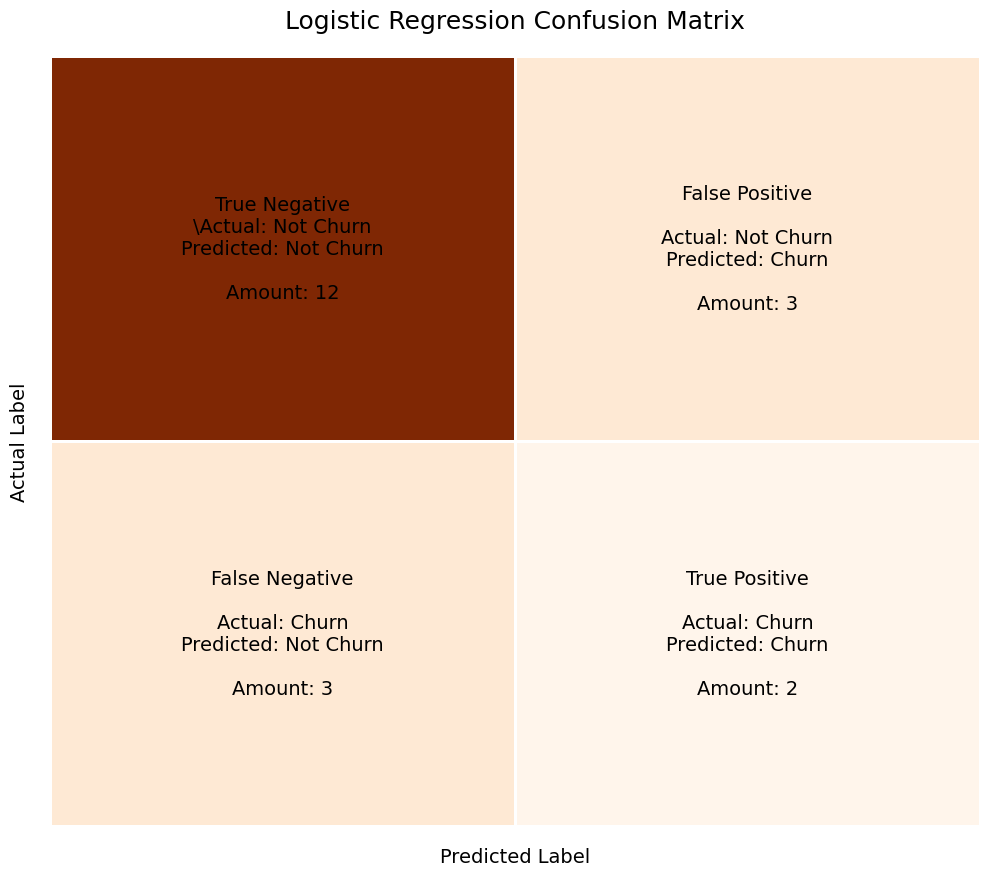

In [129]:
# Confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
tn, fp, fn, tp = conf_matrix_lr.ravel() 

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(conf_matrix_lr,
            annot=False,  
            cmap='Oranges',
            ax=ax,
            linewidths=1.0,
            cbar=False) 

ax.text(0.5, 0.5, 
        f'True Negative\n\Actual: Not Churn\nPredicted: Not Churn\n\nAmount: {tn}',
        horizontalalignment='center', verticalalignment='center',
        fontsize=14, color='black', wrap=True)


ax.text(1.5, 0.5, 
        f'False Positive\n\nActual: Not Churn\nPredicted: Churn\n\nAmount: {fp}',
        horizontalalignment='center', verticalalignment='center',
        fontsize=14, color='black', wrap=True)


ax.text(0.5, 1.5, 
        f'False Negative\n\nActual: Churn\nPredicted: Not Churn\n\nAmount: {fn}',
        horizontalalignment='center', verticalalignment='center',
        fontsize=14, color='black', wrap=True)


ax.text(1.5, 1.5, 
        f'True Positive\n\nActual: Churn\nPredicted: Churn\n\nAmount: {tp}',
        horizontalalignment='center', verticalalignment='center',
        fontsize=14, color='black', wrap=True)


ax.set_title('Logistic Regression Confusion Matrix', fontsize=18, pad=20)
ax.set_xticks([])
ax.set_yticks([])

ax.set_xlabel('Predicted Label', fontsize=14, labelpad=15)
ax.set_ylabel('Actual Label', fontsize=14, labelpad=15)

plt.show()


## 4.5 Model Interpretation (Coefficients)

Show top **positive coefficients** (churn drivers) and top **negative coefficients** (retention/protective factors).

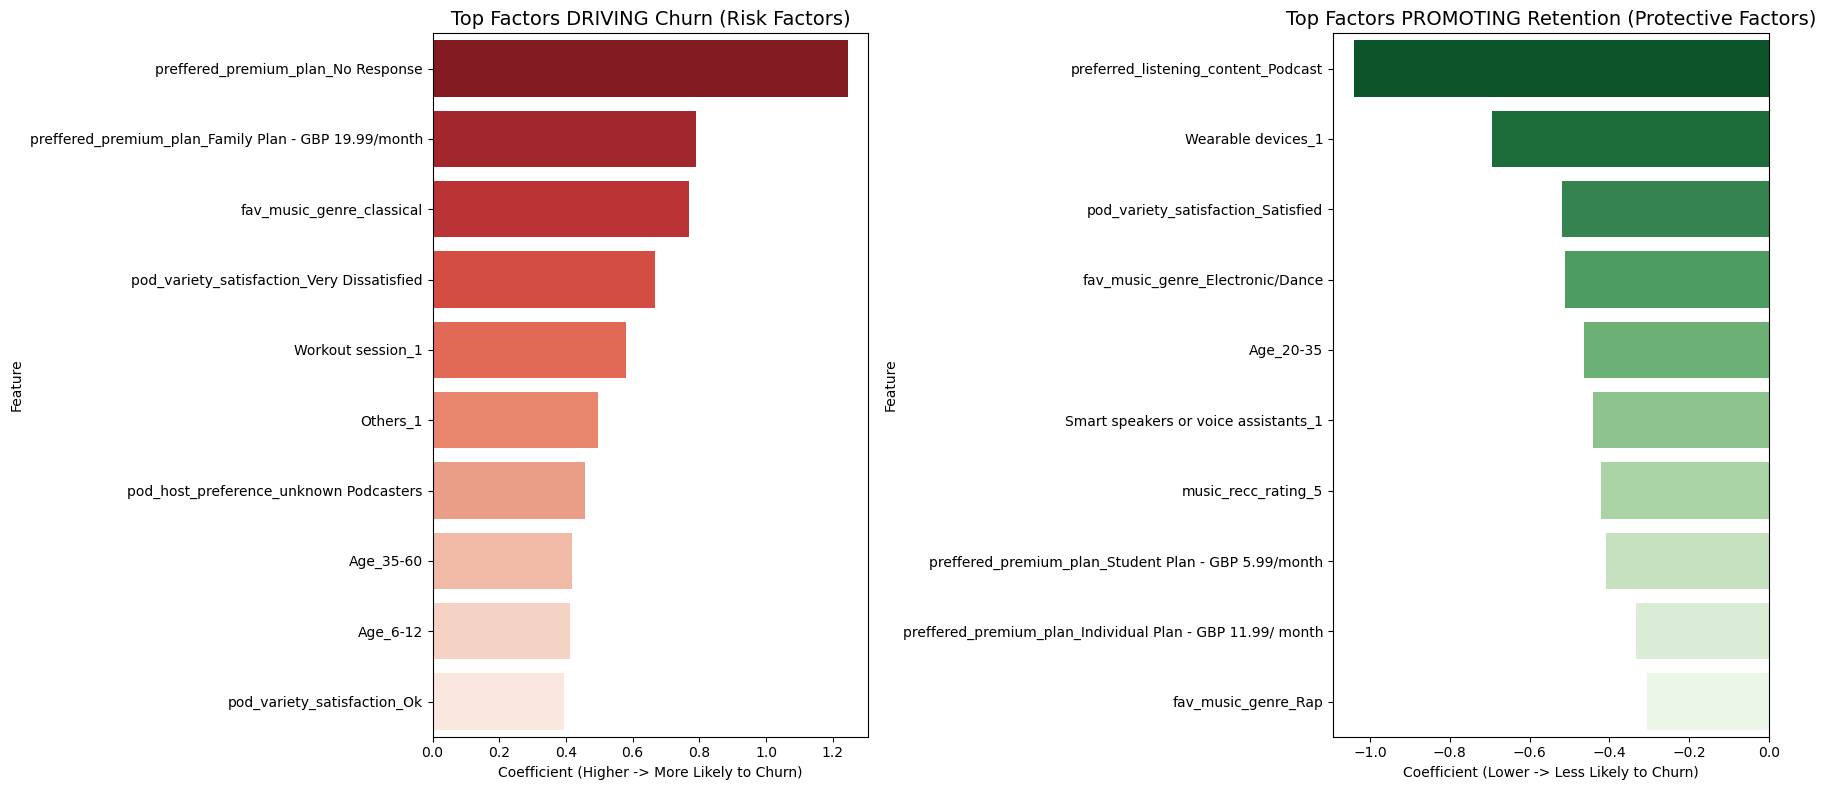

In [130]:
coefficients = lr_model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Top positive (churn drivers) and top negative (retention factors)
churn_drivers = coef_df.sort_values(by='Coefficient', ascending=False).head(10)
retention_factors = coef_df.sort_values(by='Coefficient', ascending=True).head(10)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.barplot(x='Coefficient', y='Feature', data=churn_drivers, ax=axes[0], palette='Reds_r')
axes[0].set_title('Top Factors DRIVING Churn (Risk Factors)', fontsize=14)
axes[0].set_xlabel('Coefficient (Higher -> More Likely to Churn)')

sns.barplot(x='Coefficient', y='Feature', data=retention_factors, ax=axes[1], palette='Greens_r')
axes[1].set_title('Top Factors PROMOTING Retention (Protective Factors)', fontsize=14)
axes[1].set_xlabel('Coefficient (Lower -> Less Likely to Churn)')

plt.tight_layout()
plt.show()

**Key Findings:**

The logistic regression model achieved **70% overall accuracy**, performing well in identifying non-churn users (precision and recall = 0.80) but moderately in detecting churners (0.40), likely due to class imbalance. 

The confusion matrix shows most misclassifications occur in predicting churners as retained users. Feature importance analysis highlights that users without a clear premium plan preference, **Family Plan** subscribers, and **classical** music listeners are most prone to churn, alongside those **dissatisfied with podcast variety**. 

Conversely, podcast listeners, **wearable device** users, and those **satisfied with content diversity** show higher retention. **Student and Individual Plan** users also demonstrate stronger loyalty. These insights suggest that improving satisfaction and targeting disengaged Family Plan users could substantially reduce churn.